In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'../python/')

from startup import *

In [3]:
problem_id='MHD_4pc_new'

In [4]:

to_Myr=(c.pc/(u.km/u.s)).to('Myr').value 
# taxis is already in units of Myr
t1=200#/to_Myr
t2=500#/to_Myr
t3=550#/to_Myr # time when net mass flux is nearly zero
z1=1000
z2=3000

In [5]:
class data_container(object):
    def __init__(self,pid,base='../data/',t1=200,t2=500,t3=550,z1=1000,z2=3000):
        zpfname='{}{}.merged.nc'.format(base,pid)
        self.data_orig=xr.open_dataset(zpfname)
        snfname='{}{}.sn'.format(base,pid)
        self.sn=hst_reader(snfname)
        hstfname='{}{}.hst'.format(base,pid)
        self.hst=hst_reader(hstfname)
        
        self.set_ranges(t1=t1,t2=t2,t3=t3,z1=z1,z2=z2)
        self.data=self.initial_processing(self.data_orig)
        self.split_data(self.data)
        self.colors={'warm':'C2','int':'C1','hot':'C3','whole':'C0'}

    def set_units(self,data):
        import astropy.constants as c
        import astropy.units as u
        self.G = c.G.cgs.value
        self.Msun = c.M_sun.cgs.value
        self.pc = c.pc.cgs.value
        self.pi = np.pi
        self.m_unit = 1.4271*c.m_p.cgs.value*self.pc**3
        self.l_unit = self.pc
        self.v_unit = 1.e5
        self.t_unit = self.l_unit/self.v_unit
        self.G_code = (self.G/self.l_unit**3)*self.m_unit*self.t_unit**2
        self.rho_unit = self.m_unit/self.l_unit**3

        self.p_unit = self.rho_unit*self.v_unit**2#m_unit * (1./l_unit) / t_unit/ t_unit
        self.E_unit = self.p_unit*self.l_unit**3
        self.deltaz = data.zaxis.data[1]-data.zaxis.data[0]
        self.totarea=float(data['A'].sel(phase='whole')[0,0].data)
        self.kb = c.k_B.cgs.value
        self.to_Myr=(c.pc/(u.km/u.s)).to('Myr').value 
        self.dt=np.diff(data.taxis).mean()/self.to_Myr
        self.esn = 1.e51/self.E_unit
        self.mej = 10*self.Msun/self.m_unit
        
    def set_ranges(self,t1=200,t2=500,t3=550,z1=1000,z2=3000):
        # Note taxis is already in units of Myr
        self.t1=t1
        self.t2=t2
        self.t3=t3
        self.z1=z1
        self.z2=z2
        #print(rho_unit, p_unit, pc, deltaz, kb)
        
    def initial_processing(self,data_orig):        
        t1=self.t1
        t2=self.t2
        t3=self.t3
        
        data_sel=xr.concat([data_orig.sel(taxis=slice(t1,456.)),data_orig.sel(taxis=slice(456.1,t3))],dim='taxis')
        data_sum=data_sel.sum(dim='phase').expand_dims('phase')
        data_sum.coords['phase']=['all']
        data=xr.concat([data_sel,data_sum],dim='phase')
        data.coords['phase']=['cold','unstable','warm','int','hot','whole']
        data['p_flux_kin']=2.0*data['Ek3']
        data['p_flux_mag']=data['PB1']+data['PB2']-data['PB3']
        data['m_flux']=np.sign(data.zaxis)*data['M3']
        data['p_flux']=data['p_flux_kin']+data['p_flux_mag']+data['P']
        data['vz']=data['pFzM3']/data['pFzd']
        data['ekin_flux']=np.sign(data.zaxis)*(data['pFzE1']+data['mFzE1']+data['pFzE2']+data['mFzE2']+data['pFzE3']+data['mFzE3'])
        data['eth_flux']=np.sign(data.zaxis)*(data['pFzP']+data['mFzP'])
        data['eg_flux']=np.sign(data.zaxis)*(data['pFzEge']+data['mFzEge']+
                                             data['pFzEgsg']+data['mFzEgsg']+
                                             data['pFzEtidal']+data['mFzEtidal'])
        data['e_flux']=data['ekin_flux']+data['eth_flux']+data['eg_flux']
        data['ekin']=data['Ek1']+data['Ek2']+data['Ek3']
        data['eth']=1.5*data['P']
        data['emag']=data['PB1']+data['PB2']+data['PB3']
        data['etot']=data['ekin']+data['eth']+data['emag']
        
        self.set_units(data)
        return data
    
    def split_data(self,data):
        
        t1=self.t1
        t2=self.t2
        t3=self.t3
        z1=self.z1
        z2=self.z2
        
        data_u=data.sel(taxis=slice(t1,t3),zaxis=slice(z1,z2)).isel(phase=slice(2,6))
        data_l=data.sel(taxis=slice(t1,t3),zaxis=slice(-z2,-z1)).isel(phase=slice(2,6))
        data_u.coords['z']=data_u.zaxis
        data_l.coords['z']=data_l.zaxis
        data_l=data_l.reindex({'zaxis':data_l['zaxis'][::-1]})
        data_l.coords['zaxis']=np.abs(data_l.zaxis)
        
        self.data_u=data_u
        self.data_l=data_l
        
    def get_tavg(self,data):

        avg=data.mean(dim='taxis')/self.totarea
        avg['totcool']=self.get_source_term(data['cool'])
        avg['totheat']=self.get_source_term(data['heat'])
        avg['netcool']=avg['totcool']-avg['totheat']
        
        return avg

    def get_flux_diff(self,avg):
        
        z1=self.z1
        z2=self.z2
        deltaz=self.deltaz
        
        avg1=avg.sel(zaxis=z1,method='nearest')
        avg2=avg.sel(zaxis=z2,method='nearest')
        davg=avg-avg1

        davg['Wext']=np.sign(avg.z)*avg['dWext'].cumsum(dim='zaxis')*deltaz
        davg['Wsg']=np.sign(avg.z)*avg['dWsg'].cumsum(dim='zaxis')*deltaz
        davg['W']=davg['Wext']+davg['Wsg']
        davg['m_balance']=davg['m_flux']
        davg['p_balance']=davg['p_flux']+davg['W']
        davg['e_balance']=davg['e_flux']+avg['netcool']

        return davg

    def get_source_term(self,data):
        
        deltaz=self.deltaz
        totarea=self.totarea
        source=data.mean(dim='taxis').cumsum(dim='zaxis')*deltaz/totarea
        source.coords['zaxis']=data.zaxis
        return source

    def get_dt_term(self,data):
        
        t1=self.t1
        t3=self.t3
        deltaz=self.deltaz
        totarea=self.totarea
        
        dq=data.sel(taxis=t3,method='nearest')-data.sel(taxis=t1,method='nearest')
        dt=(t3-t1)/self.to_Myr
        dqdt=dq.cumsum(dim='zaxis')*deltaz/totarea/dt
        dqdt.coords['zaxis']=data.zaxis
        return dqdt

    def get_sn_source_term(self):
        
        z1=self.z1
        z2=self.z2
        deltaz=self.deltaz
        sn=self.sn
        
        zbin=np.arange(z1,z2+deltaz,deltaz)
        sn_select=sn[(sn.time > t1/self.to_Myr) & (sn.time < t3/self.to_Myr)]
        dt=(t3-t1)/self.to_Myr
        NSN_u=np.histogram(sn_select.x3,bins=zbin)
        NSN_l=np.histogram(sn_select.x3,bins=-zbin[::-1])
        nsn_u=NSN_u[0].cumsum()
        nsn_l=NSN_l[0][::-1].cumsum()
        self.esn_u=nsn_u*self.esn/self.totarea/dt
        self.esn_l=nsn_l*self.esn/self.totarea/dt
        self.msn_u=nsn_u*self.mej/self.totarea/dt
        self.msn_l=nsn_l*self.mej/self.totarea/dt

def plot_data(data,colors=None,legend=True,**kwargs):
    if colors is None: colors={'warm':'C2','int':'C1','hot':'C3','whole':'C0'}
    for ph in data.coords['phase'].data:
        plt.plot(data.zaxis,data.sel(phase=ph),color=colors[ph],label=ph,**kwargs)
    if legend: plt.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

In [6]:
dc=data_container(problem_id,t3=550)

Reading a history file:../data/MHD_4pc_new.sn.p
Reading a history file:../data/MHD_4pc_new.hst.p


In [7]:
dc.get_sn_source_term()

# upper side

dqdt_u=dc.get_dt_term(dc.data_u)
avg_u=dc.get_tavg(dc.data_u)
davg_u=dc.get_flux_diff(avg_u)

# lower side

dqdt_l=dc.get_dt_term(dc.data_l)
avg_l=dc.get_tavg(dc.data_l)
davg_l=dc.get_flux_diff(avg_l)

0.16    0.001339
0.50    0.002815
0.84    0.007055
Name: sfr10, dtype: float64
0.16    0.001604
0.50    0.003294
0.84    0.007510
Name: sfr10, dtype: float64
0.16    0.000912
0.50    0.002633
0.84    0.005328
Name: sfr10, dtype: float64


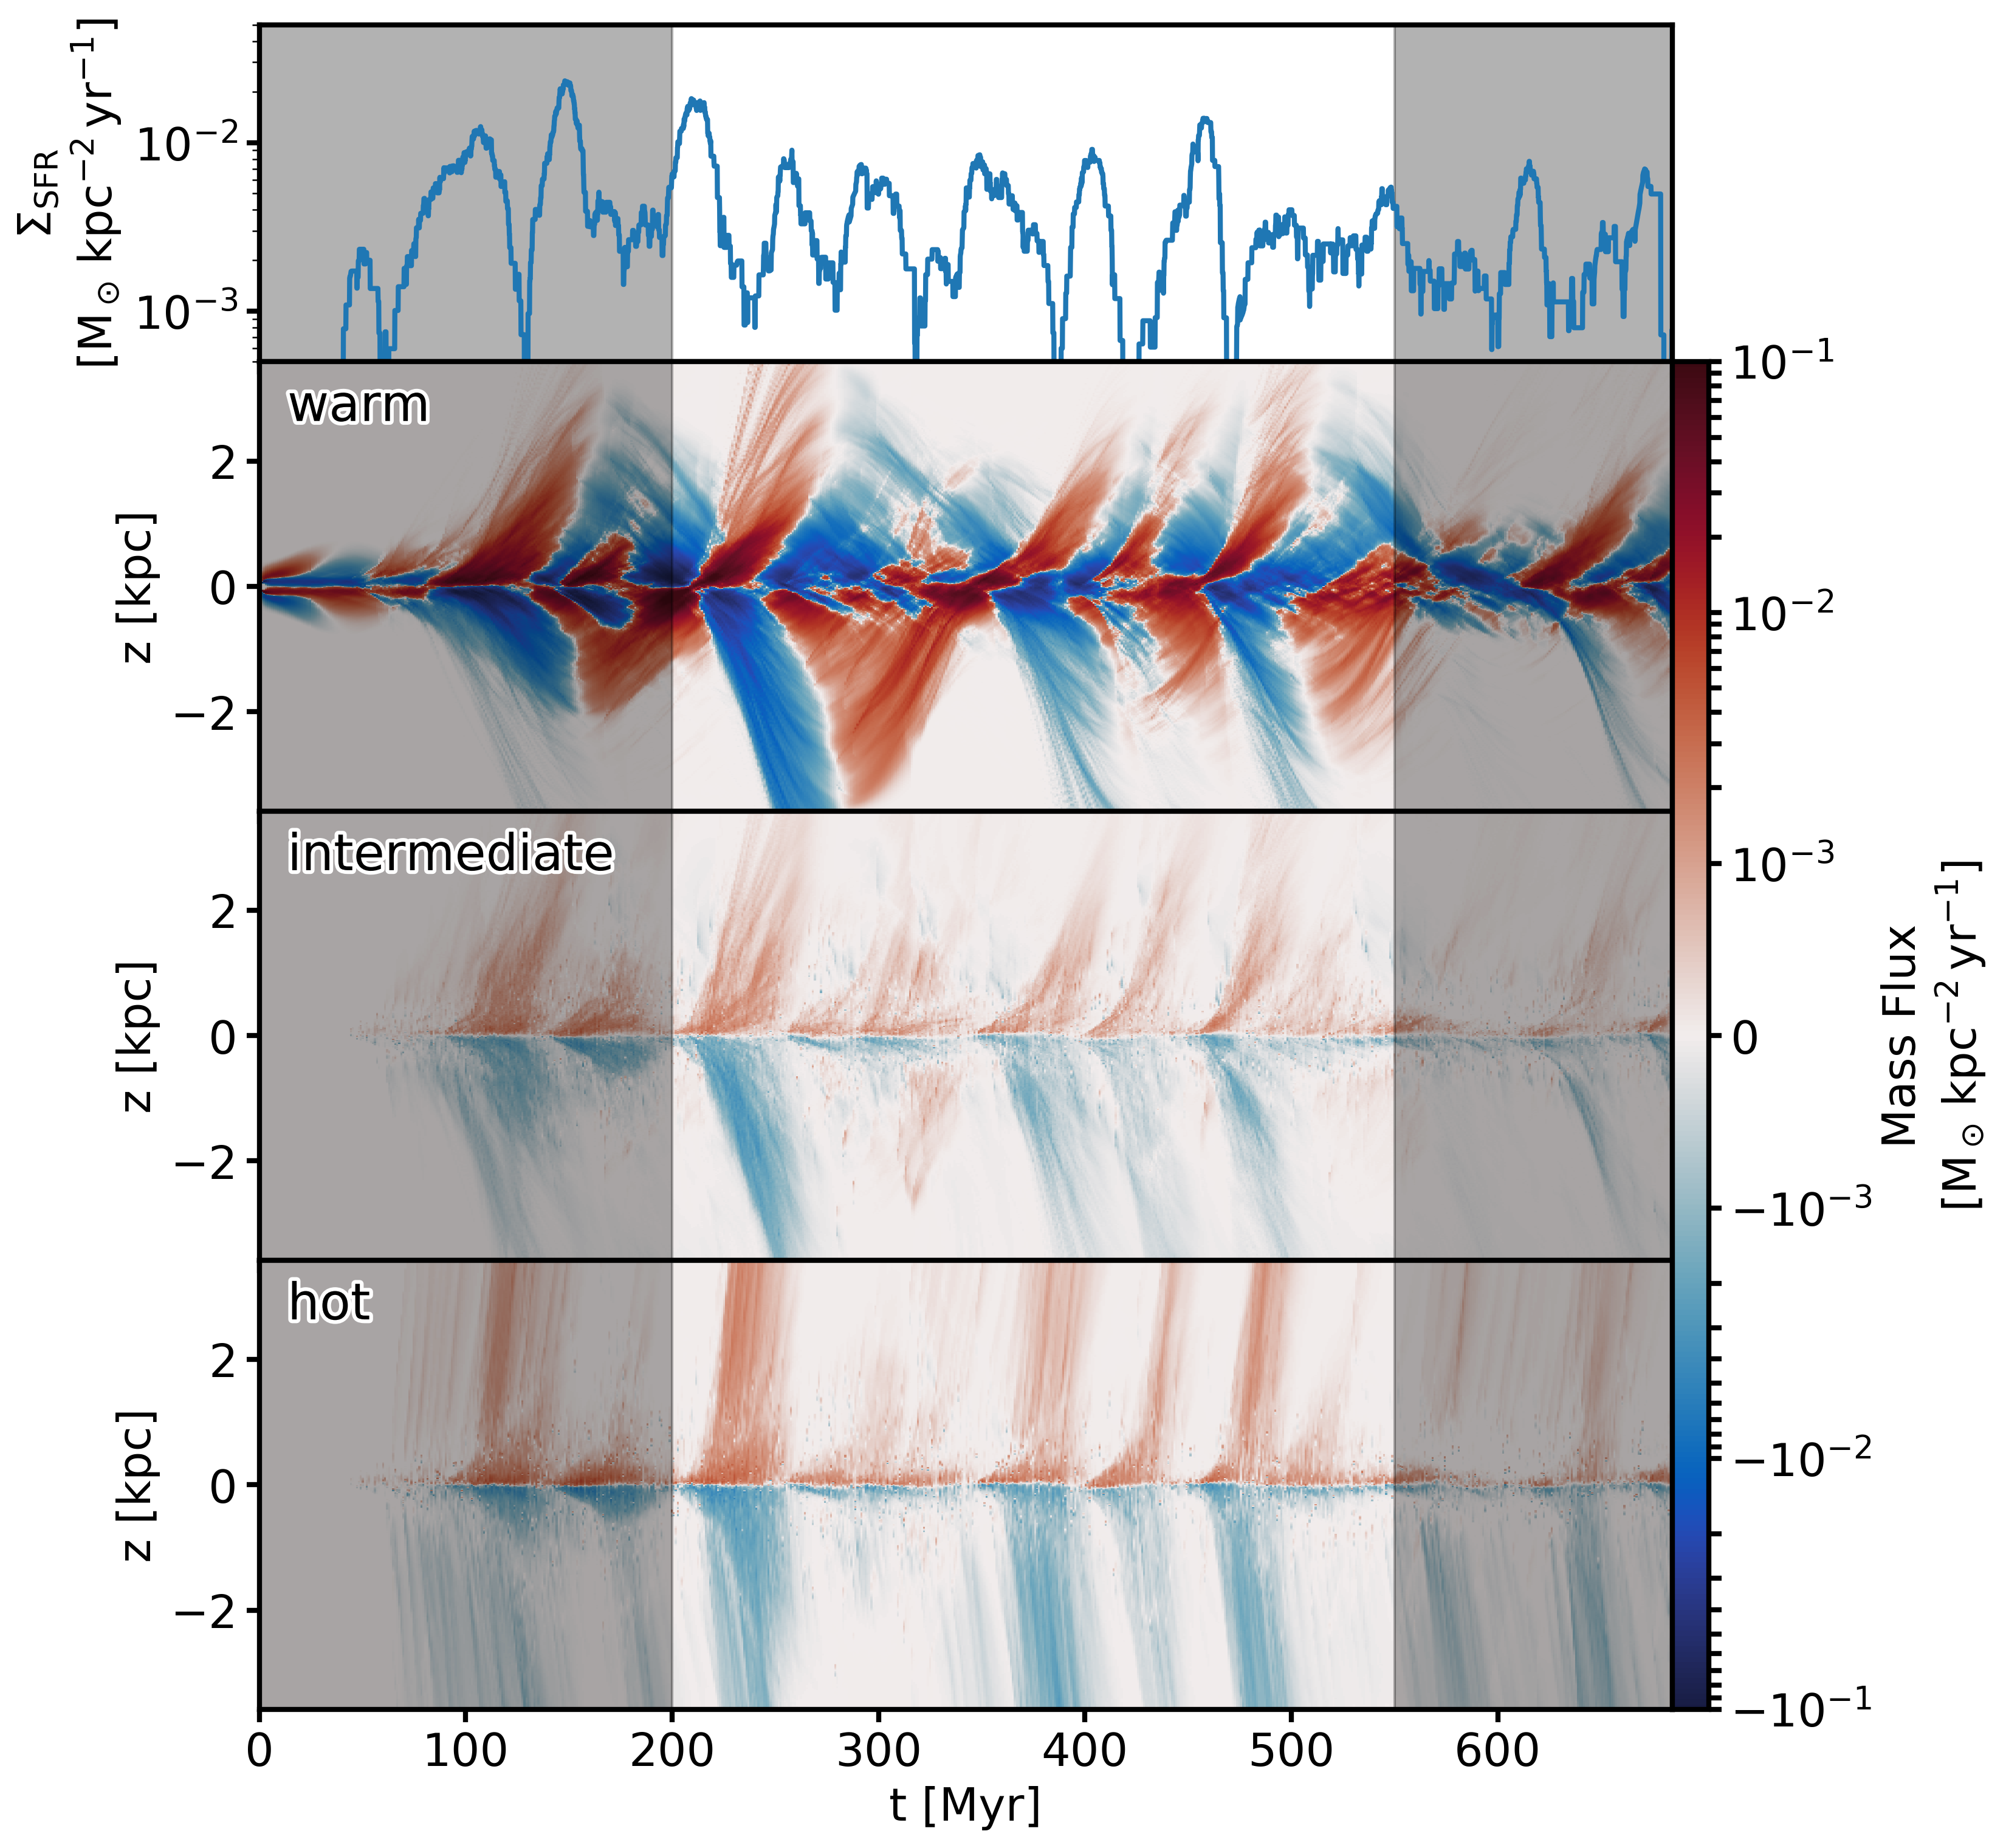

In [9]:
import cmocean
fig, axes=plt.subplots(4,1,gridspec_kw={'height_ratios':[1.5,2,2,2],'hspace':0.},figsize=(10,12),sharex=True)

ax=axes[0]
ax.plot(dc.hst['time']*dc.to_Myr,dc.hst['sfr10'],label='')
# ax.plot(dc.hst['time']*dc.to_Myr,dc.hst['sfr40'],label='')

sfrmean=dc.hst['sfr10'].mean()
tMyr=dc.hst['time']*dc.to_Myr
print(dc.hst['sfr10'][(tMyr > 200) & (tMyr < 550)].quantile([0.16,0.50,0.84]))
print(dc.hst['sfr10'][(tMyr > 200) & (tMyr < 350)].quantile([0.16,0.50,0.84]))
print(dc.hst['sfr10'][(tMyr > 400) & (tMyr < 550)].quantile([0.16,0.50,0.84]))

ax.set_ylabel(r'$\Sigma_{\rm SFR}$'+'\n'+r'$[{\rm M_\odot\,kpc^{-2}\,yr^{-1}}]$')
ax.set_yscale('log')
ax.set_ylim(5.e-4,5.e-2)

data=dc.data_orig
MFunit=dc.rho_unit*dc.v_unit/dc.Msun*dc.pc**2*dc.t_unit/dc.to_Myr

for ph,ax,label in zip(['phase3','phase4','phase5'],axes[1:],['warm','intermediate','hot']):
    Mflux=data['M3'].sel(phase=ph)/dc.totarea*MFunit
    im=ax.pcolormesh(Mflux.taxis,Mflux.zaxis/1.e3,Mflux,cmap=cmocean.cm.balance,rasterized=True)
    im.set_norm(SymLogNorm(1.e-3,vmin=-1.e-1,vmax=1.e-1))

    ax.text(0.02,0.9,label,va='center',transform=ax.transAxes,**texteffect(20))

for ax in axes:
    ax.axvspan(0,dc.t1,color='k',alpha=0.3)
    ax.axvspan(dc.t3,700,color='k',alpha=0.3)
x0,y0,xl,yl=ax.get_position().bounds
cax=fig.add_axes([x0+xl,y0,0.02,yl*3])
cbar=fig.colorbar(im,cax=cax,label=r'Mass Flux'+'\n'+r'$[{\rm M_\odot\,kpc^{-2}\,yr^{-1}}]$')
ax.set_xlabel('t [Myr]')
plt.setp(axes[1:],'ylabel','z [kpc]')
ax.set_xlim(0,Mflux.taxis.max())
fig.savefig('../figures/Mflux_tz.pdf',bbox_inches='tight',dpi=150)
fig
#fig.savefig('../figures/Mflux_tz.pdf',bbox_inches='tight')

### supplementary figure 

In [9]:
for avg,side in zip([avg_u,avg_l],['upper','lower']):
    fig,axes = plt.subplots(5,2,sharey='row',sharex=True,figsize=(12,15),
                            gridspec_kw={'wspace':0.2,'hspace':0.1})

    labels=(r'$f_A=\langle 1\rangle$',
            r'$f_M=\langle \rho\rangle/\langle \rho\rangle_{\rm whole}$',
            r'$\langle v_z\rangle/f_A$',
            r'$[\langle \rho v_z^2\rangle/\langle \rho\rangle]^{1/2}$',
            r'$\langle\rho\rangle$',
            r'$\langle\rho\rangle/f_A$',
            r'$\langle\rho v_z\rangle$',
            r'$\langle\rho v_z\rangle/f_A$',
            r'$\langle E\rangle$',
            r'$\langle E\rangle/f_A$',
           )

    for ph in avg.coords['phase'].data:
        fA=avg['A'].sel(phase=ph)
        fM=avg['d'].sel(phase=ph)/avg['d'].sel(phase='whole')
        vz=np.sign(avg.z)*avg['v3'].sel(phase=ph)/fA
        vz2=np.sqrt(2.0*avg['Ek3'].sel(phase=ph)/avg['d'].sel(phase=ph))
        d1=avg['d'].sel(phase=ph)
        d2=d1/fA
        p1=avg['m_flux'].sel(phase=ph)
        p2=p1/fA    
        e1=avg['etot'].sel(phase=ph)
        e2=e1/fA    
        z=avg.zaxis
        plist=[fA,fM,vz,vz2,d1,d2,p1,p2,e1,e2]
        for ax,field,ylabel in zip(axes.flat,plist,labels):
            ax.plot(z,field,color=dc.colors[ph],label=ph)
            ax.set_ylabel(ylabel)
    plt.setp(axes[2,:],'yscale','log')
    plt.setp(axes[4,:],'yscale','log')
    for ax in axes[-1,:]:
        ax.set_xlabel(r'$z$')
    axes[0,0].legend(loc='upper left',bbox_to_anchor=(0.0,1.3),ncol=4)
    fig.savefig('../supplement/profiles_{}.pdf'.format(side),bbox_inches='tight')
    #plt.tight_layout()

# Figure: mass conservation 

In [10]:
plt.rcParams['figure.max_open_warning']=50

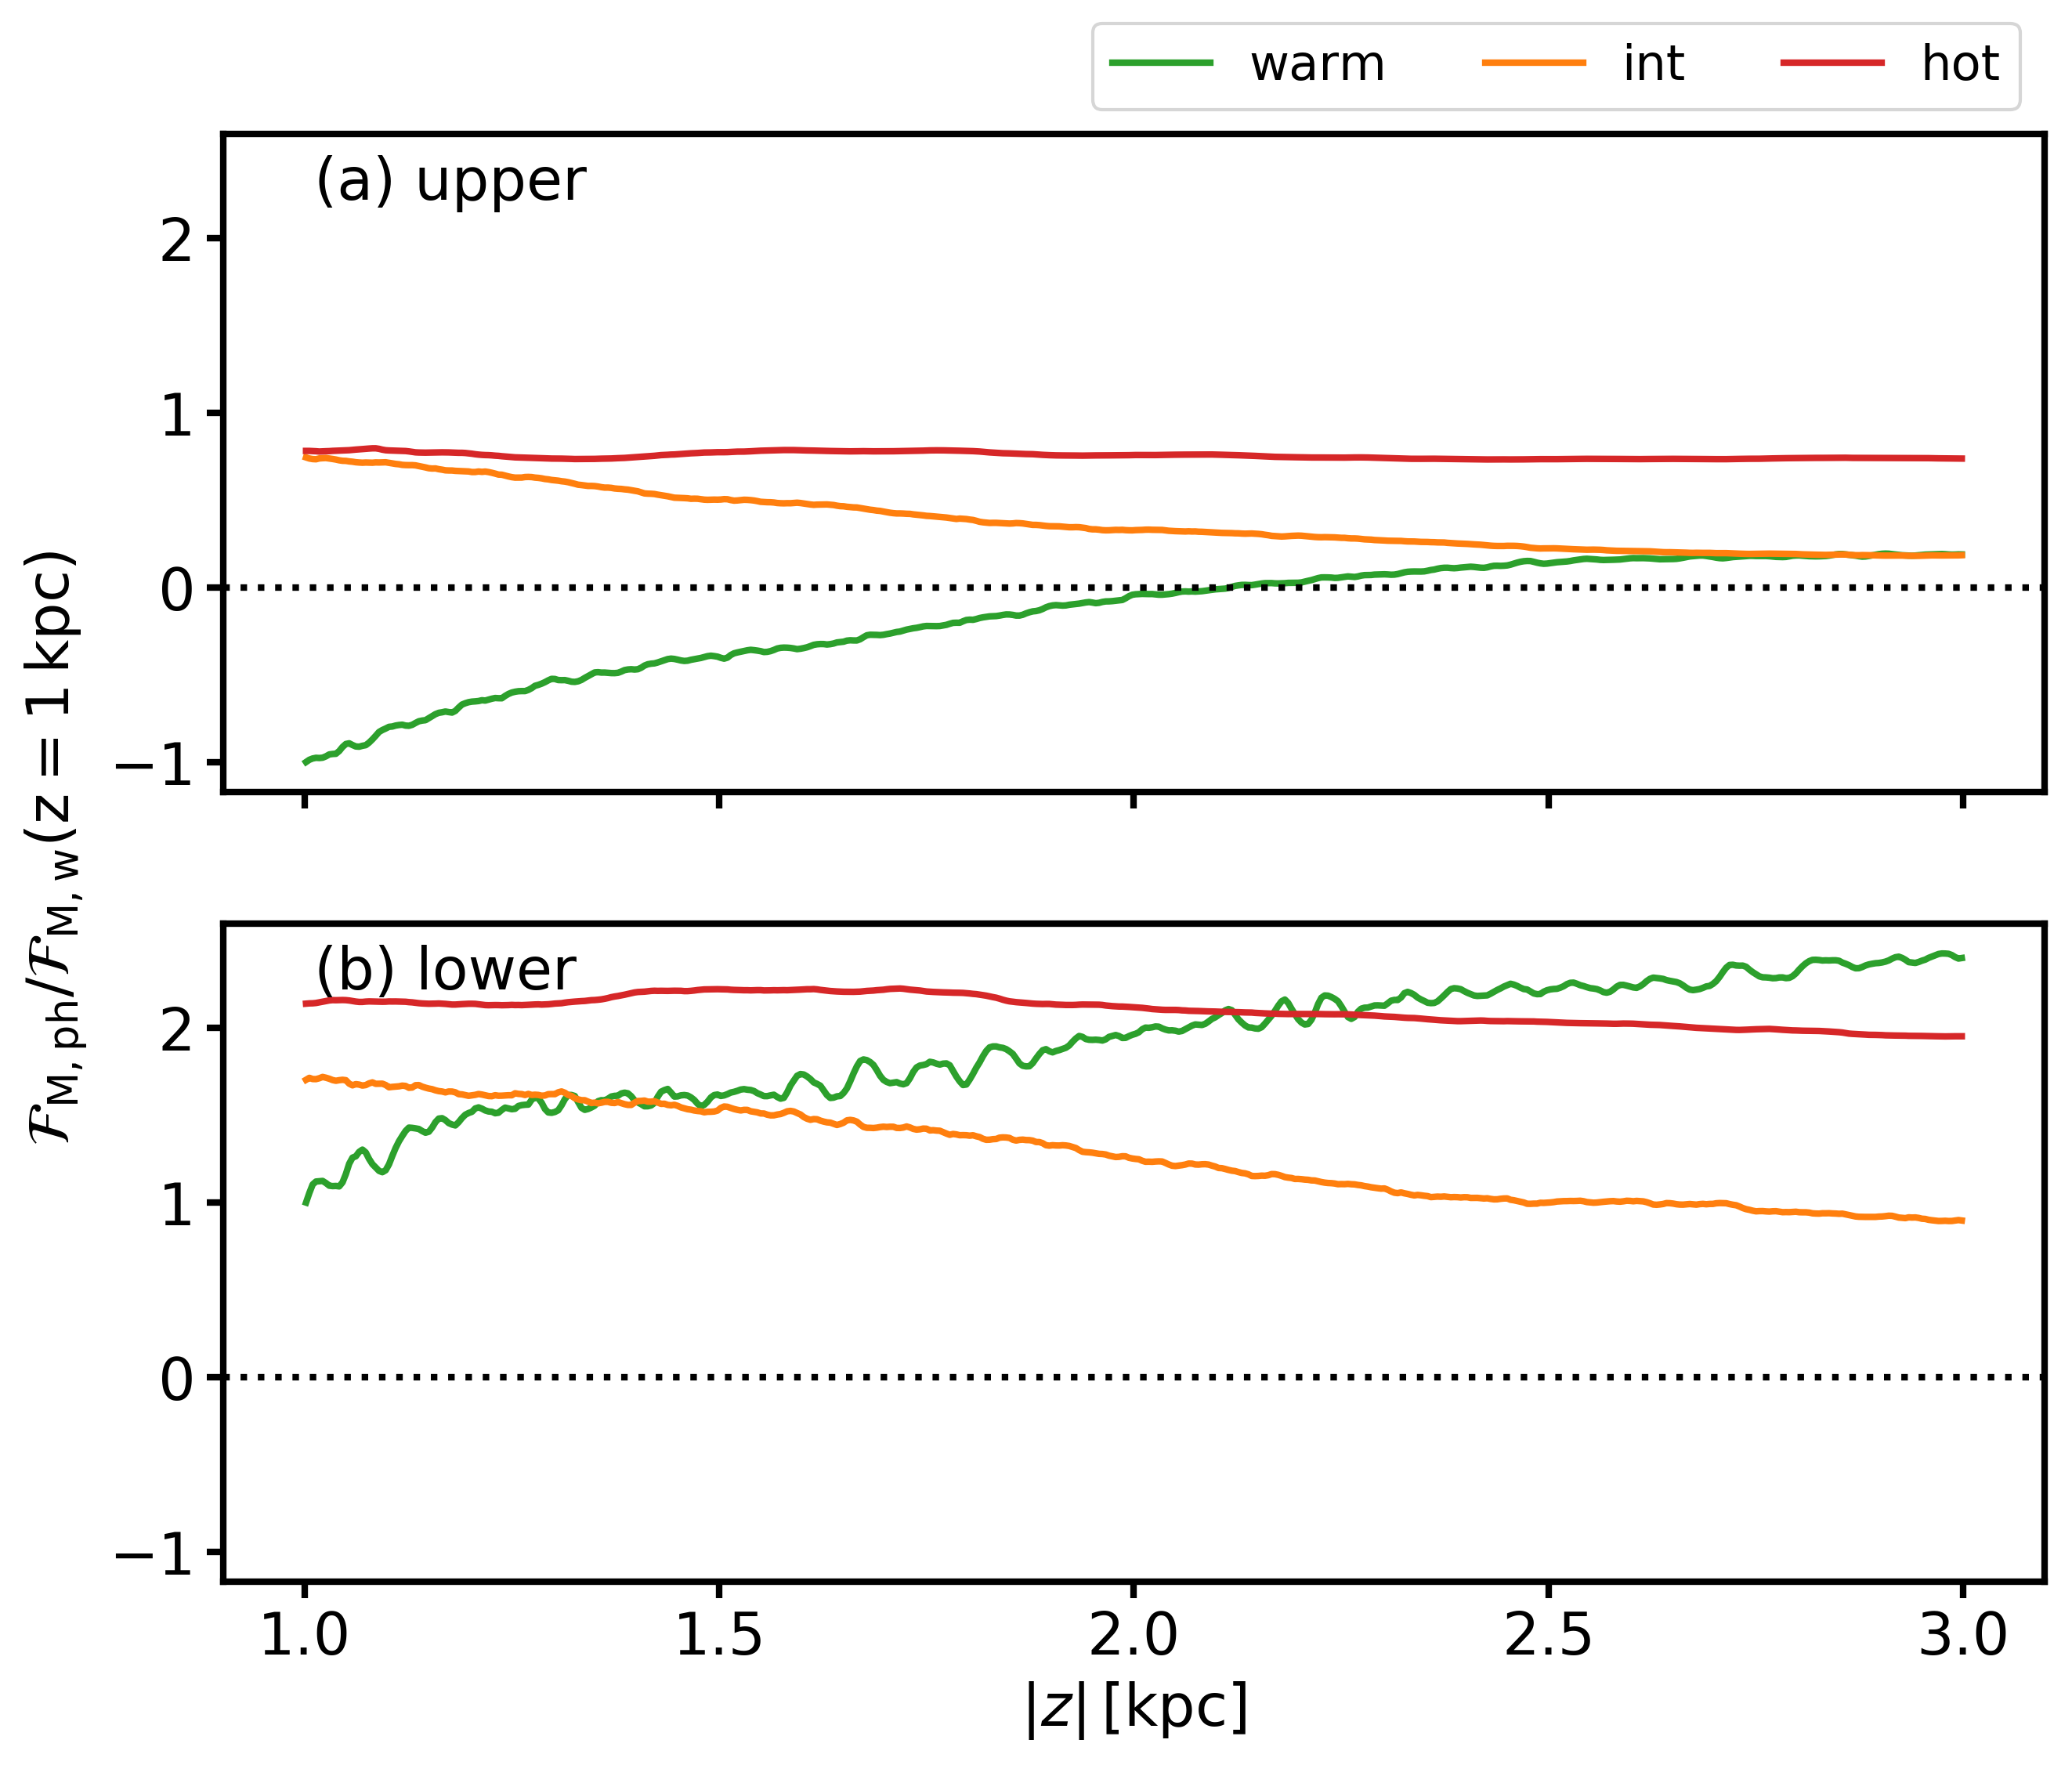

In [11]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],[dqdt_u['d'],dqdt_l['d']],axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['m_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in avg.coords['phase'].data[:-1]:
        ax.plot(davg.zaxis/1.e3,avg['m_flux'].sel(phase=ph)/ref,color=dc.colors[ph],label=ph)
    #ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,ls='--',color='k',label=r'$\Delta_t{\dot{M}}/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    #ax.set_ylim(-1.5,1.5)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.04, 0.5, r'$\mathcal{F}_{\rm M,ph}/\mathcal{F}_{\rm M,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../supplement/mass_flux_profile.pdf',bbox_inches='tight')
fig

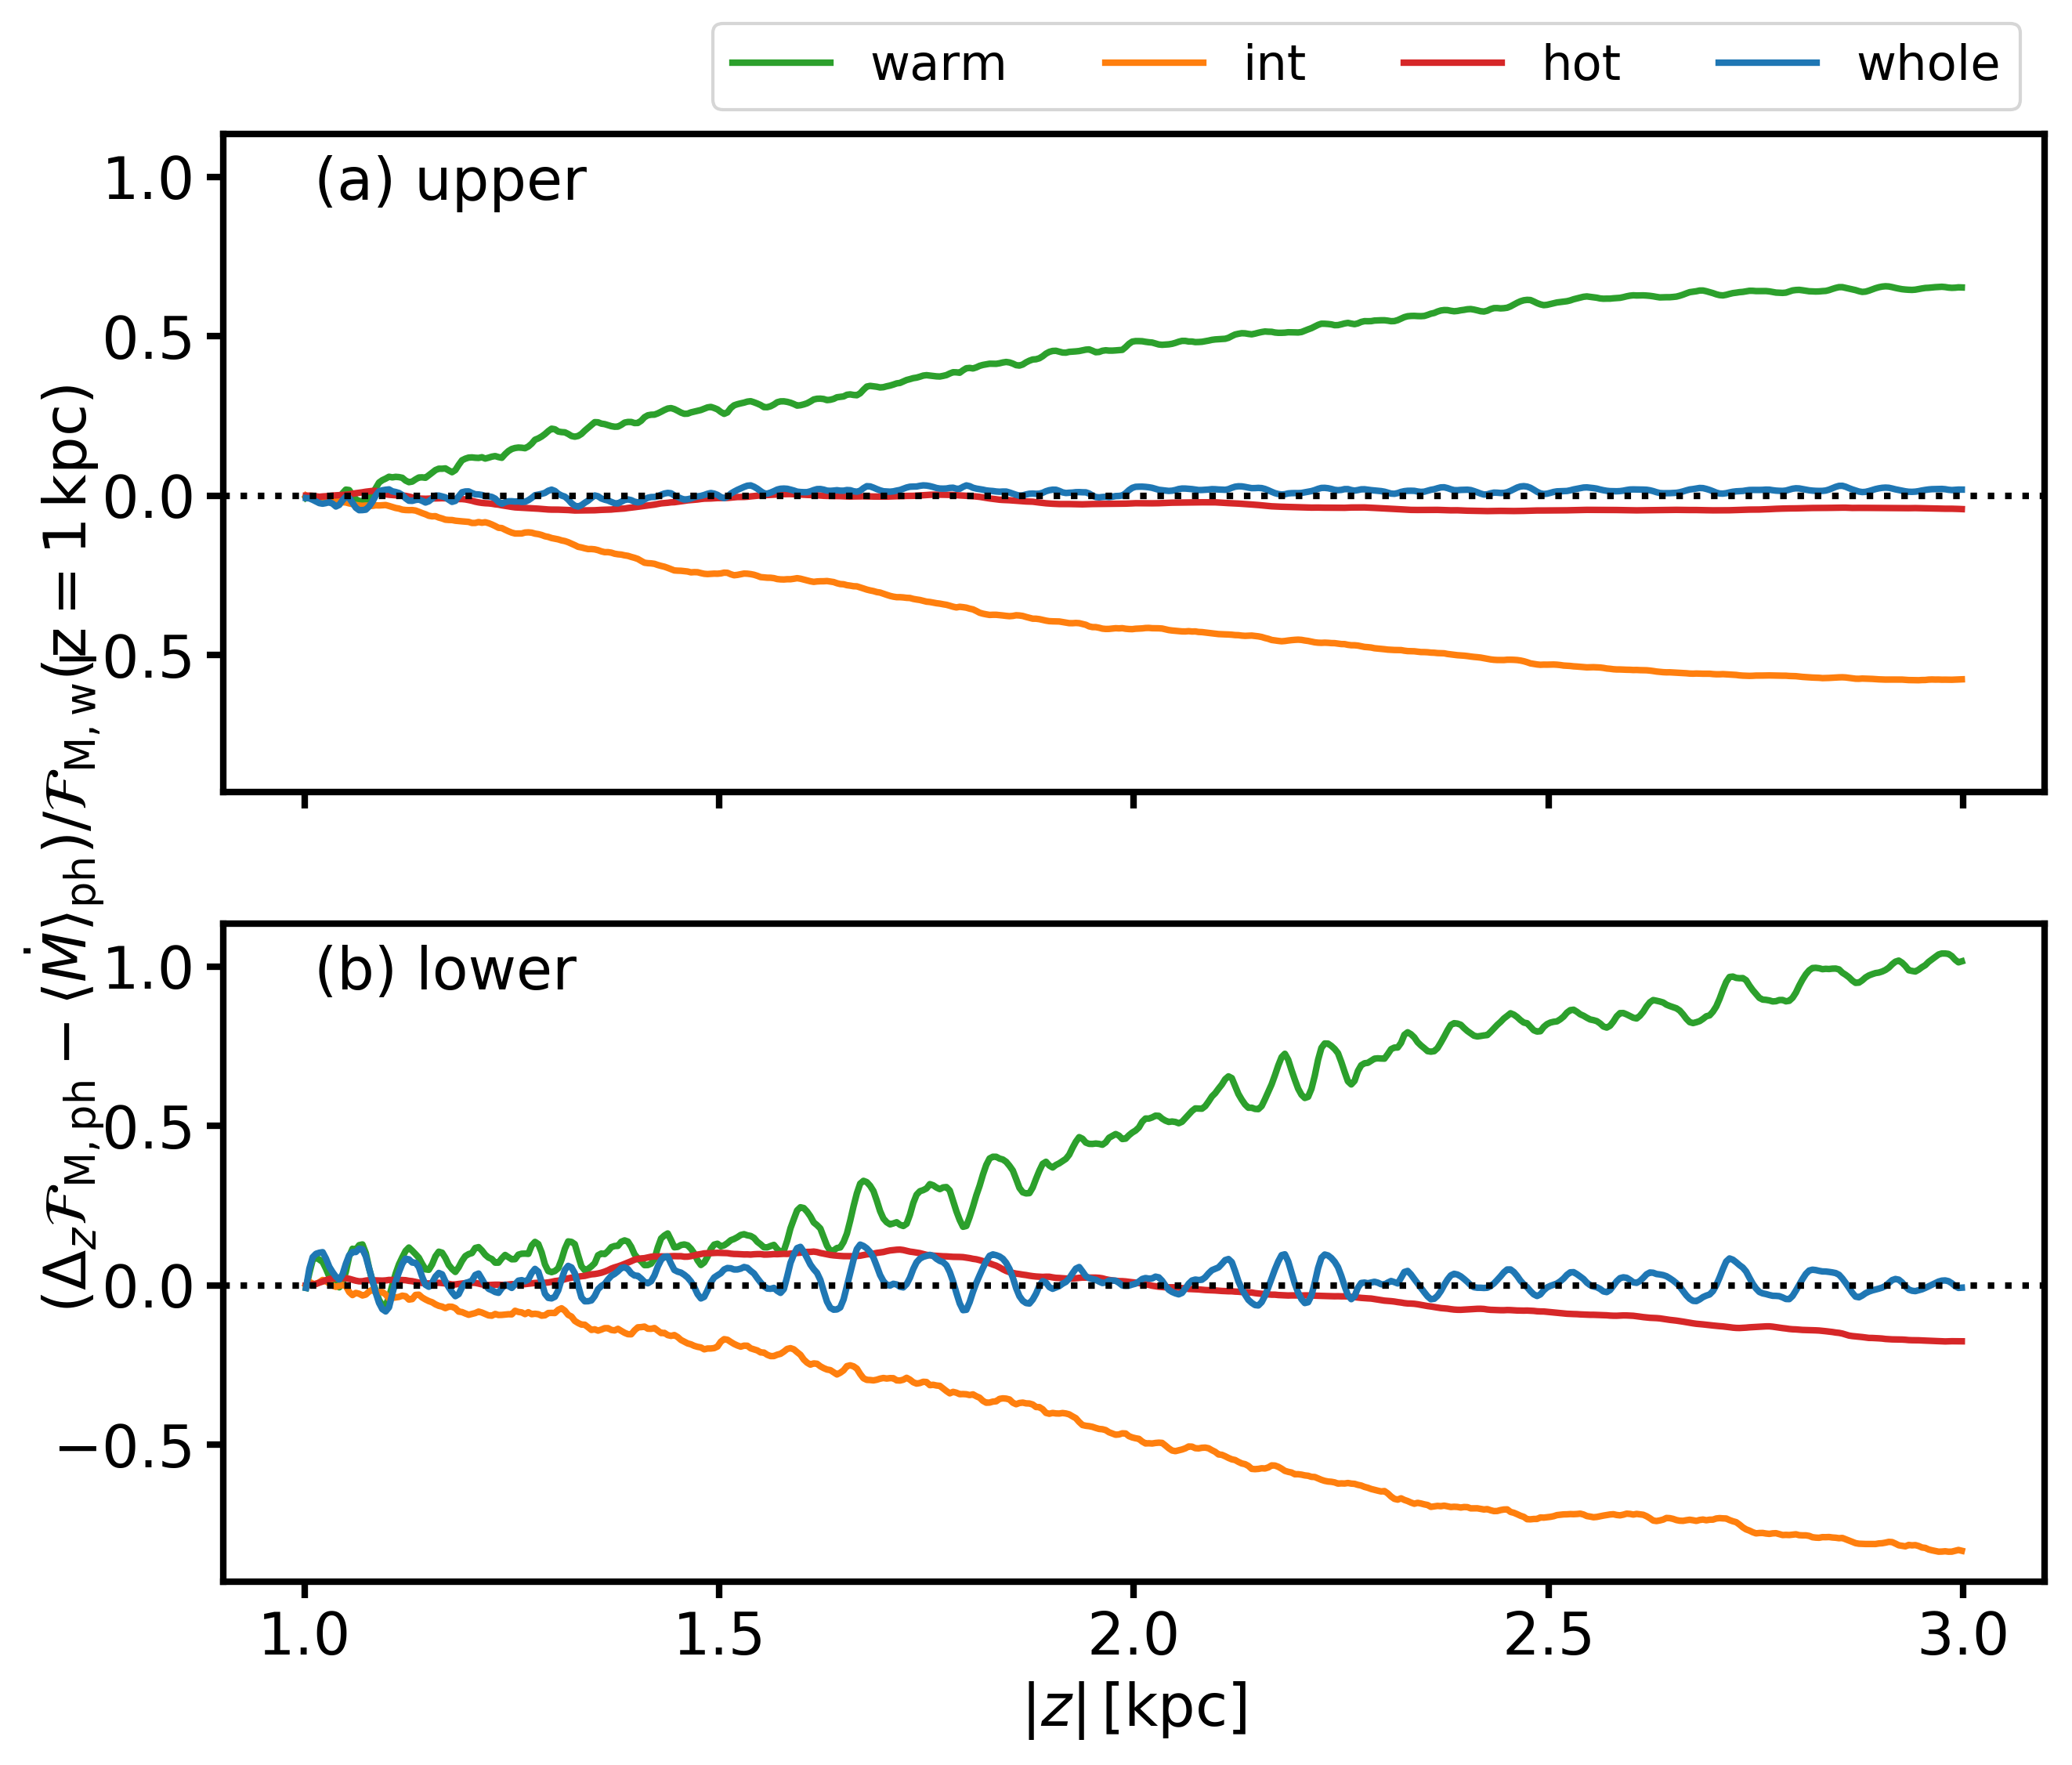

In [12]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],[dqdt_u['d'],dqdt_l['d']],axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['m_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,(davg['m_balance'].sel(phase=ph)+mdot.sel(phase=ph))/ref,color=dc.colors[ph],label=ph)
#    ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,ls='--',color='k',label=r'$\Delta_t{\dot{M}}/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    #ax.set_ylim(-1.5,1.5)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.04, 0.5, r'$(\Delta_z\mathcal{F}_{\rm M,ph}-\langle \dot{M}\rangle_{\rm ph})/\mathcal{F}_{\rm M,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../supplement/net_mass_conservation.pdf',bbox_inches='tight')
fig

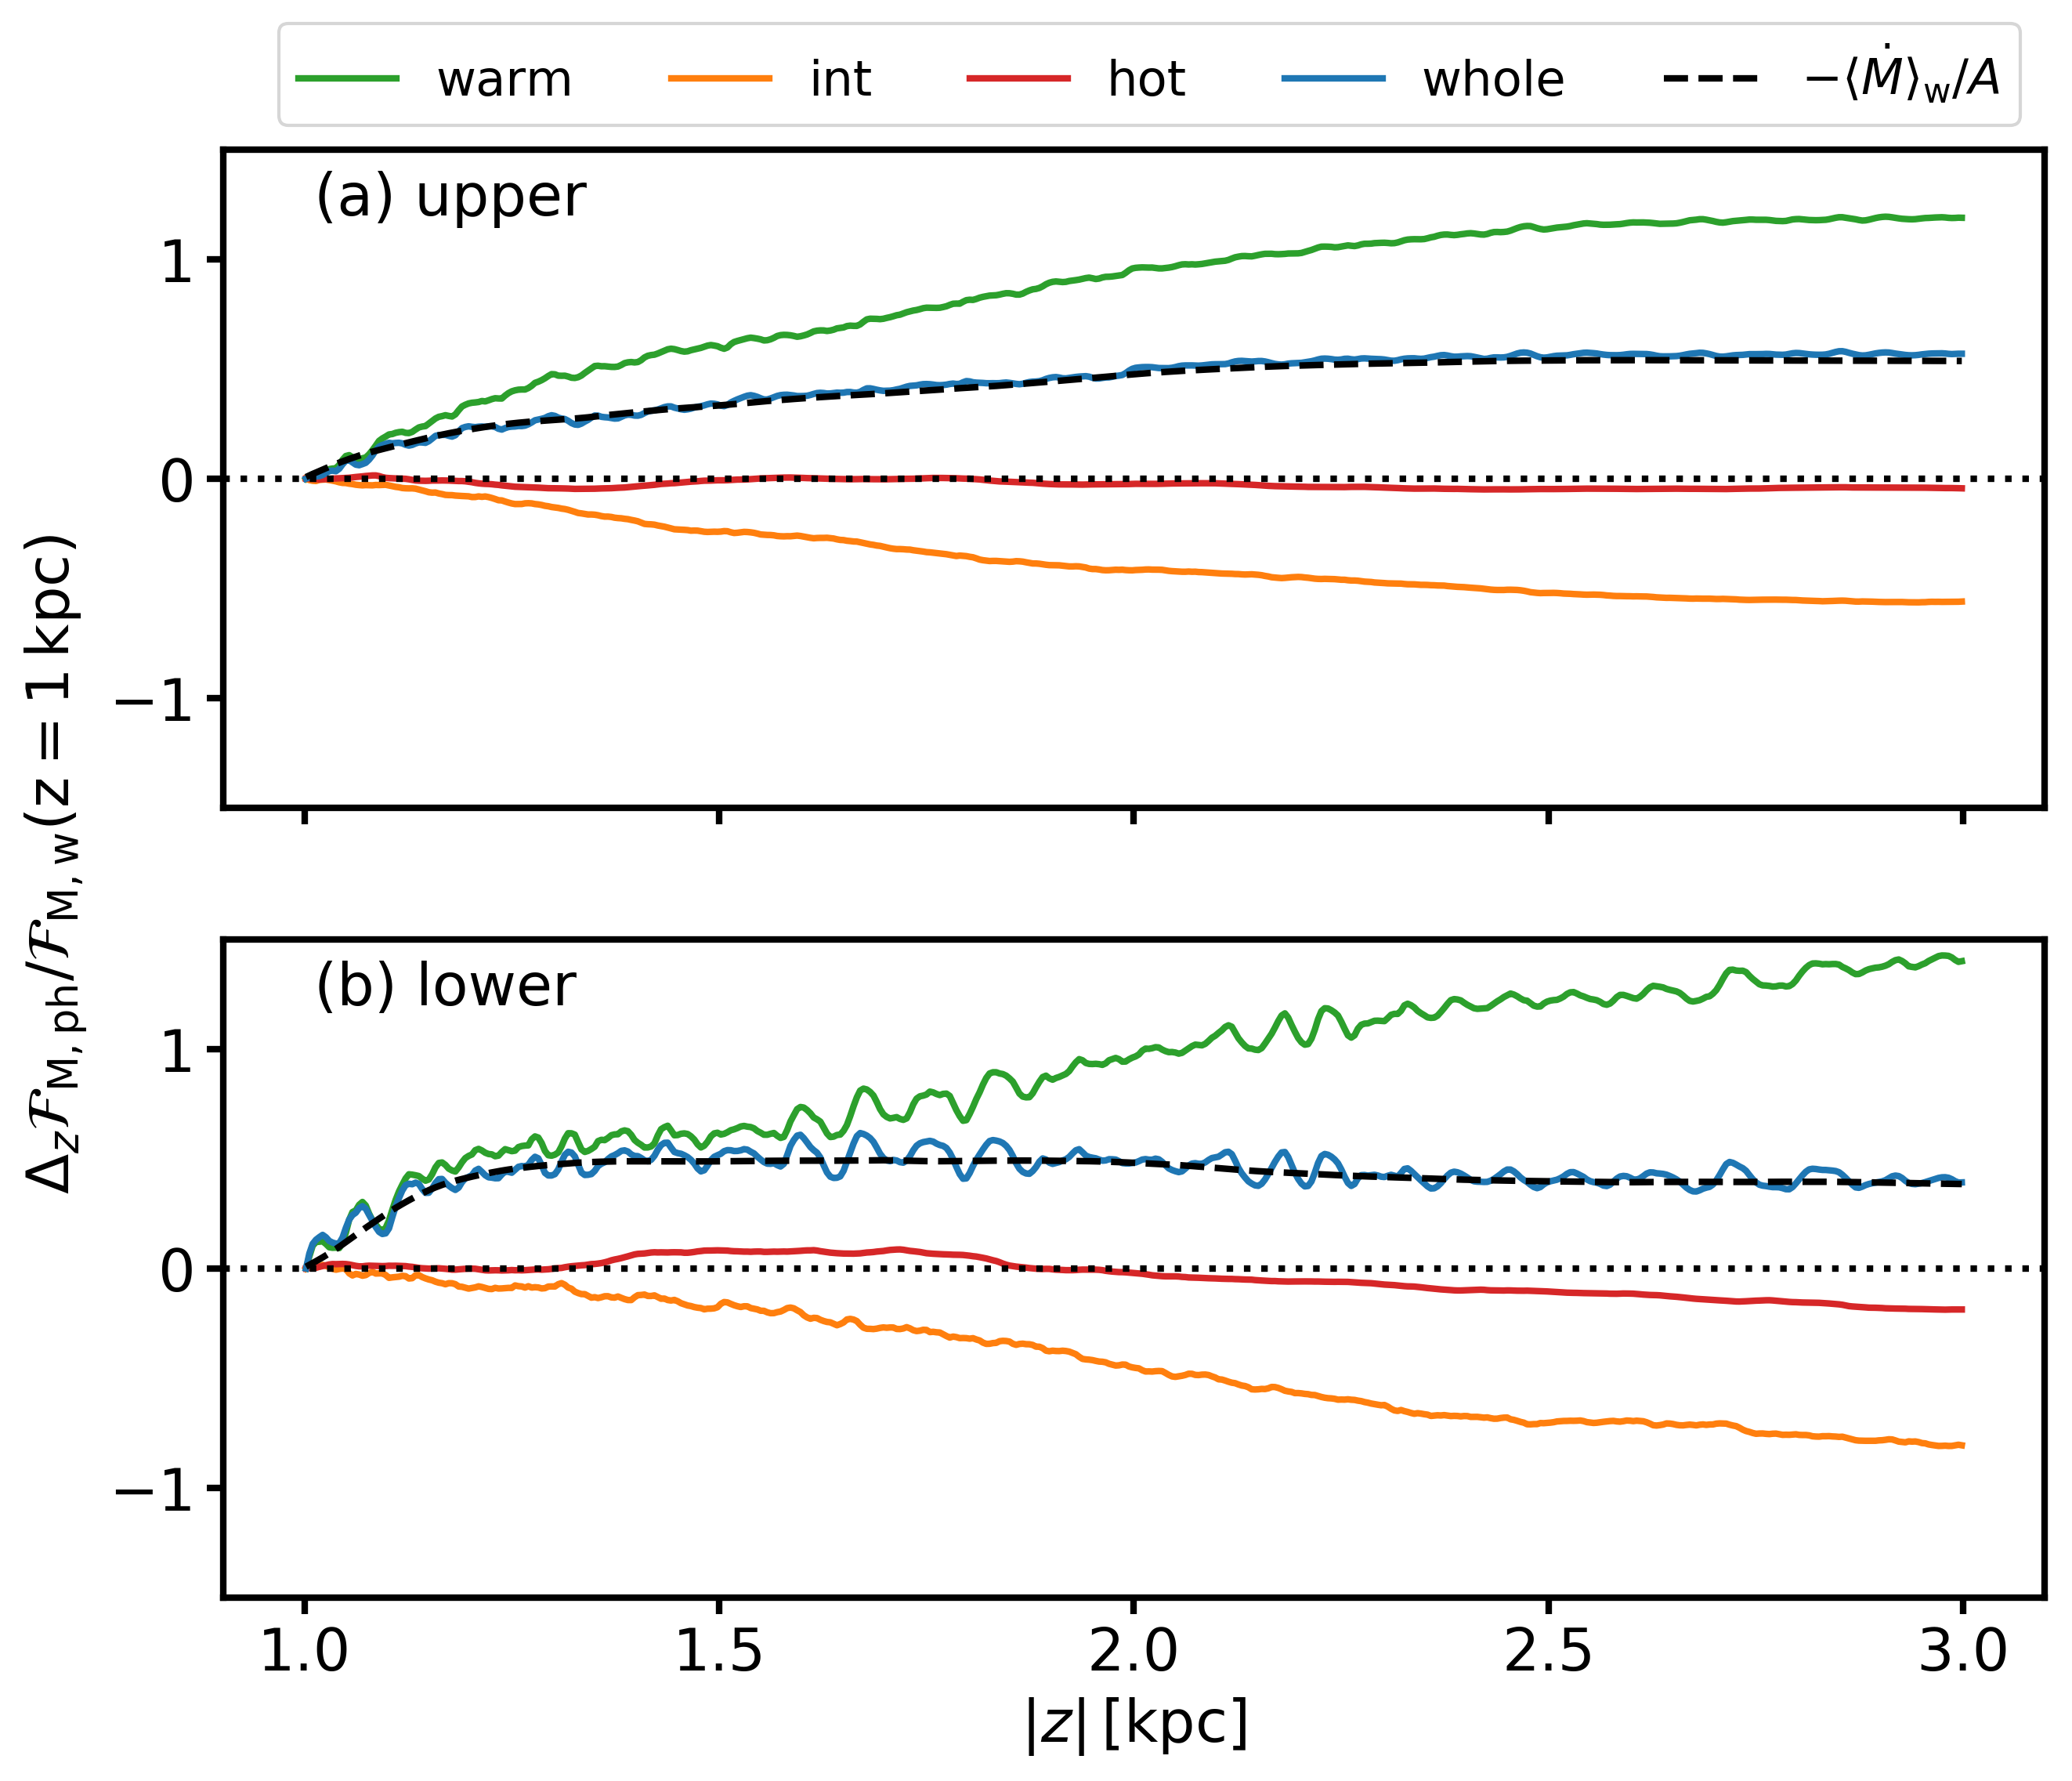

In [13]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],[dqdt_u['d'],dqdt_l['d']],axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['m_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,davg['m_balance'].sel(phase=ph)/ref,color=dc.colors[ph],label=ph)
    ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='warm')/ref,ls='--',color='k',
            label=r'$-\langle\dot{M}\rangle_{\rm w}/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.04, 0.5, r'$\Delta_z\mathcal{F}_{\rm M,ph}/\mathcal{F}_{\rm M,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../figures/mass_conservation.pdf',bbox_inches='tight')
fig

# Figure: momentum conservation

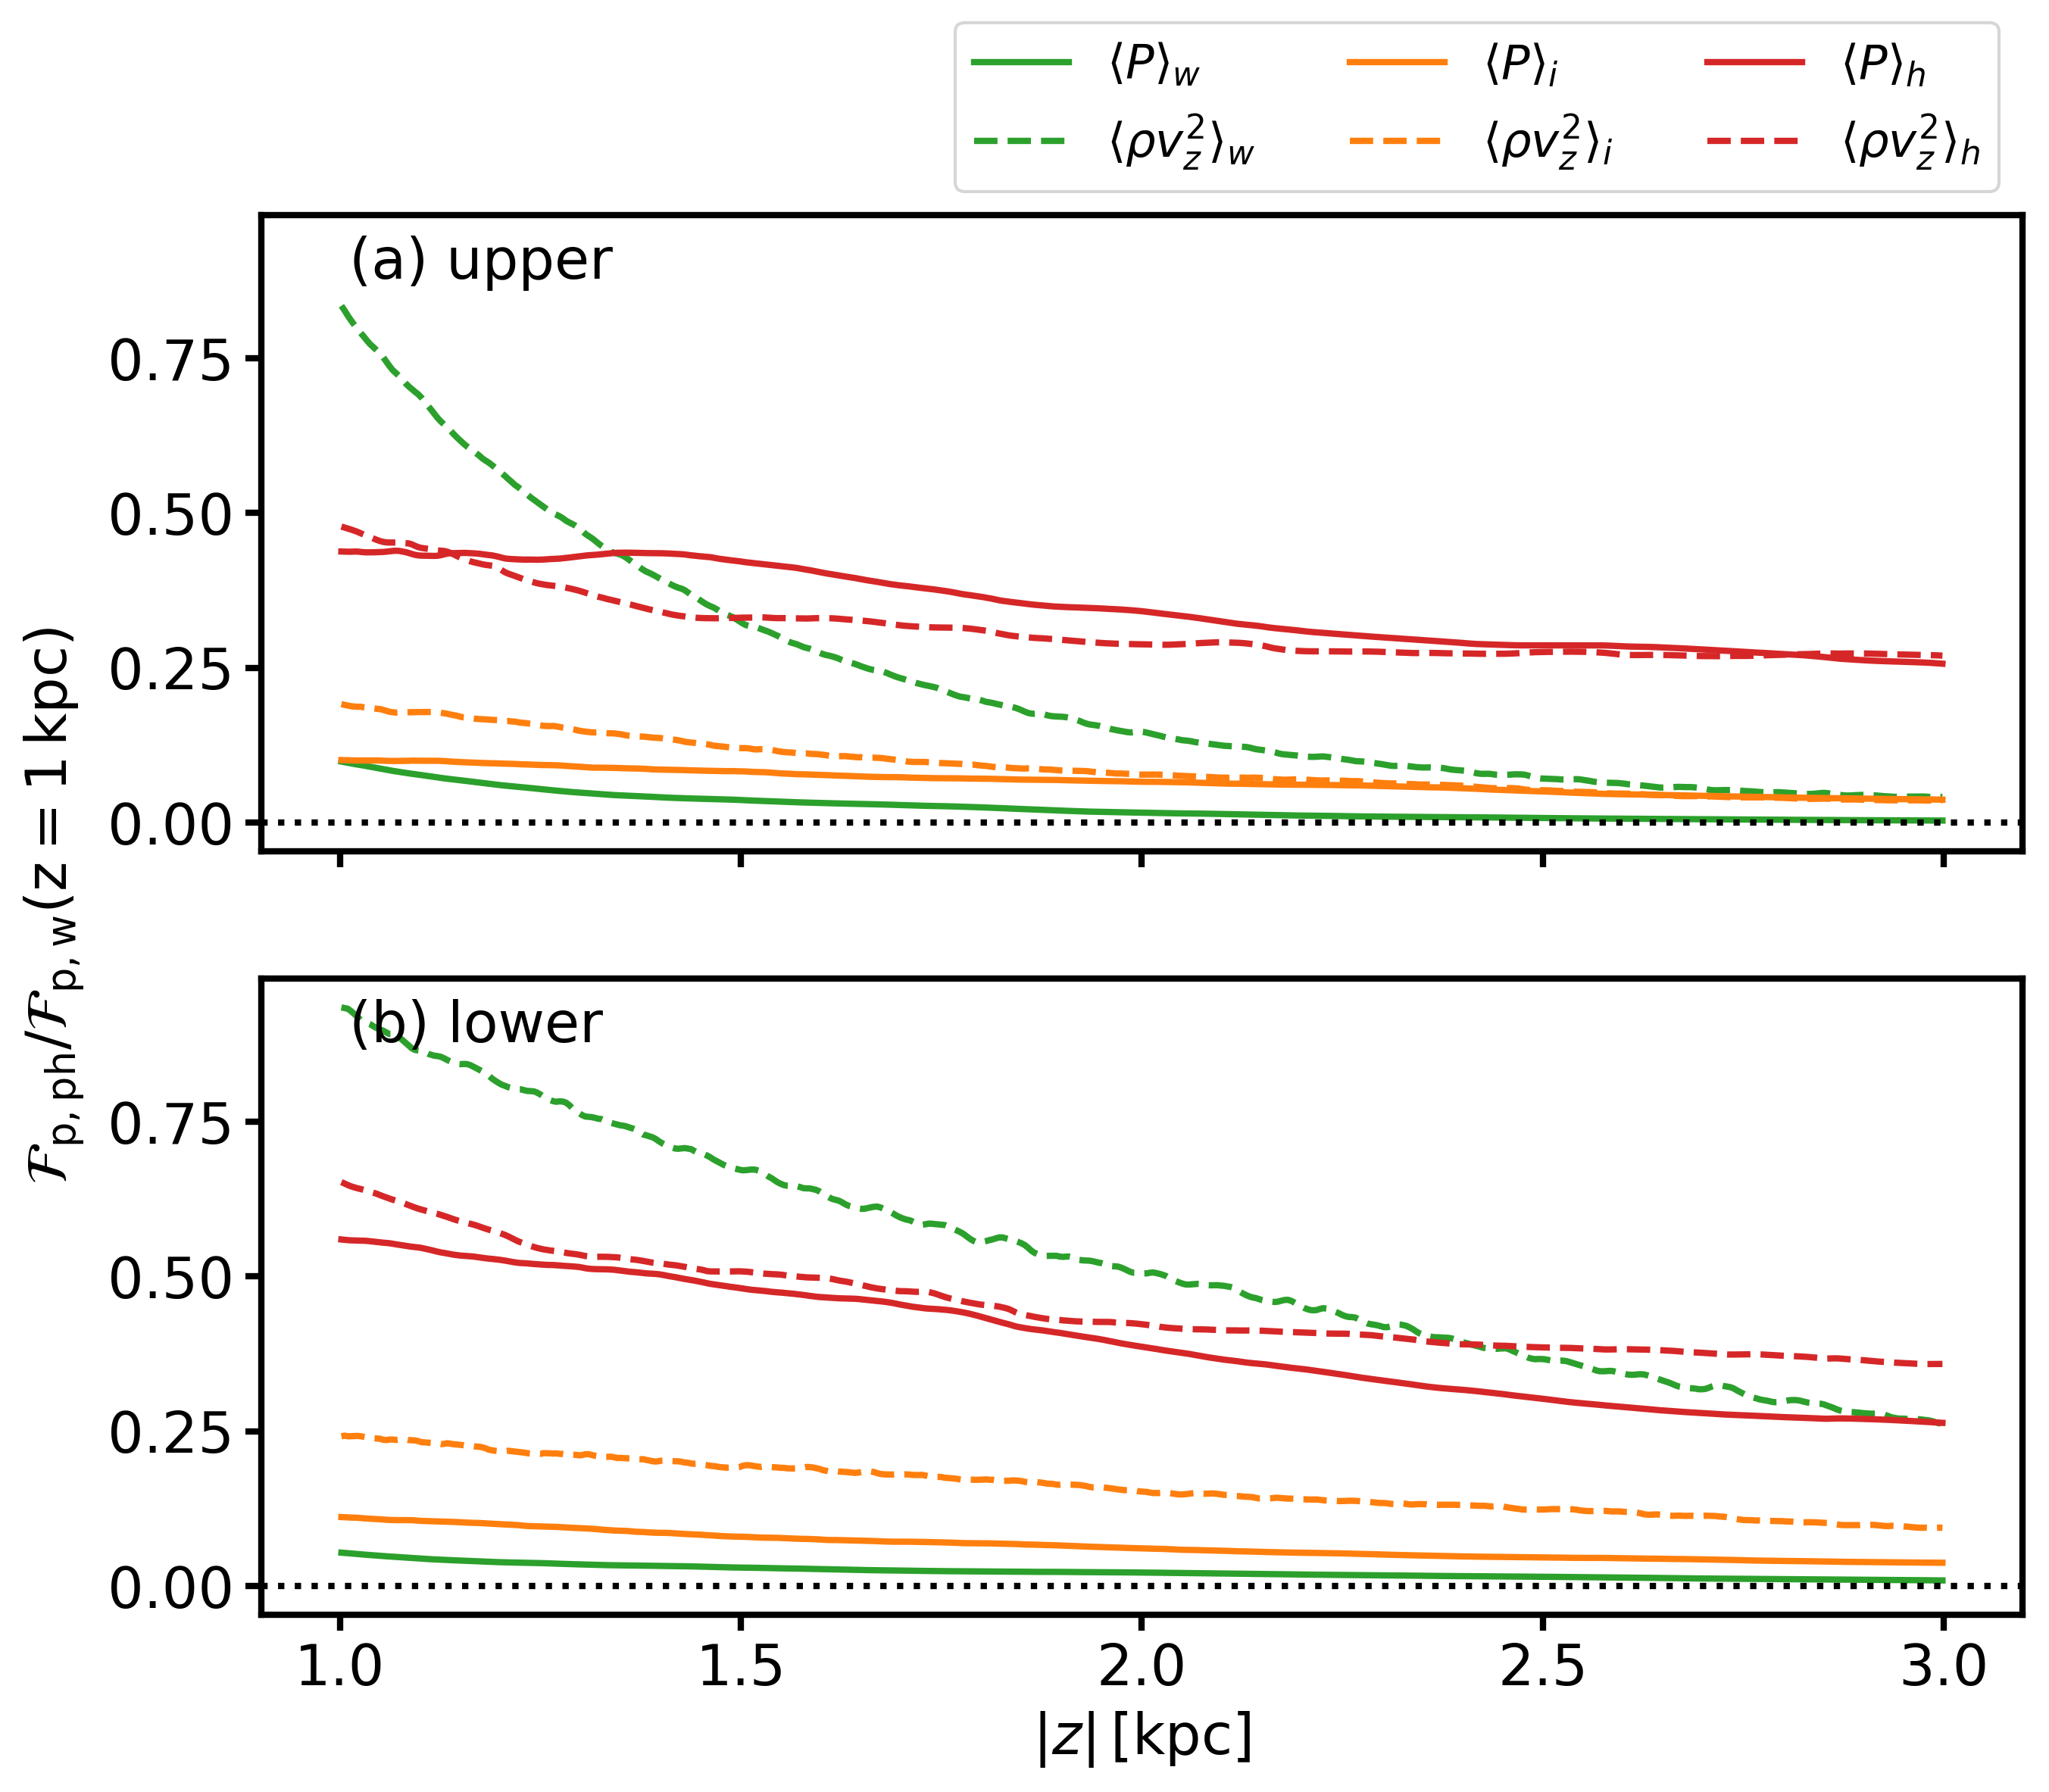

In [14]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],[dqdt_u['m_flux'],dqdt_l['m_flux']],axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['p_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in avg.coords['phase'].data[:-1]:
        ax.plot(avg.zaxis/1.e3,avg['P'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=r'$\langle P\rangle_{}$'.format(ph[0]))
        ax.plot(avg.zaxis/1.e3,avg['p_flux_kin'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=r'$\langle \rho v_z^2\rangle_{}$'.format(ph[0]),ls='--')
    #ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,ls='--',color='k',label=r'$\Delta_t{\dot{p}}/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    #ax.set_ylim(-0.7,0.7)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.02, 0.5, r'$\mathcal{F}_{\rm p,ph}/\mathcal{F}_{\rm p,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=3,fontsize='small')
fig.savefig('../supplement/momentum_flux_profile.pdf',bbox_inches='tight')
fig

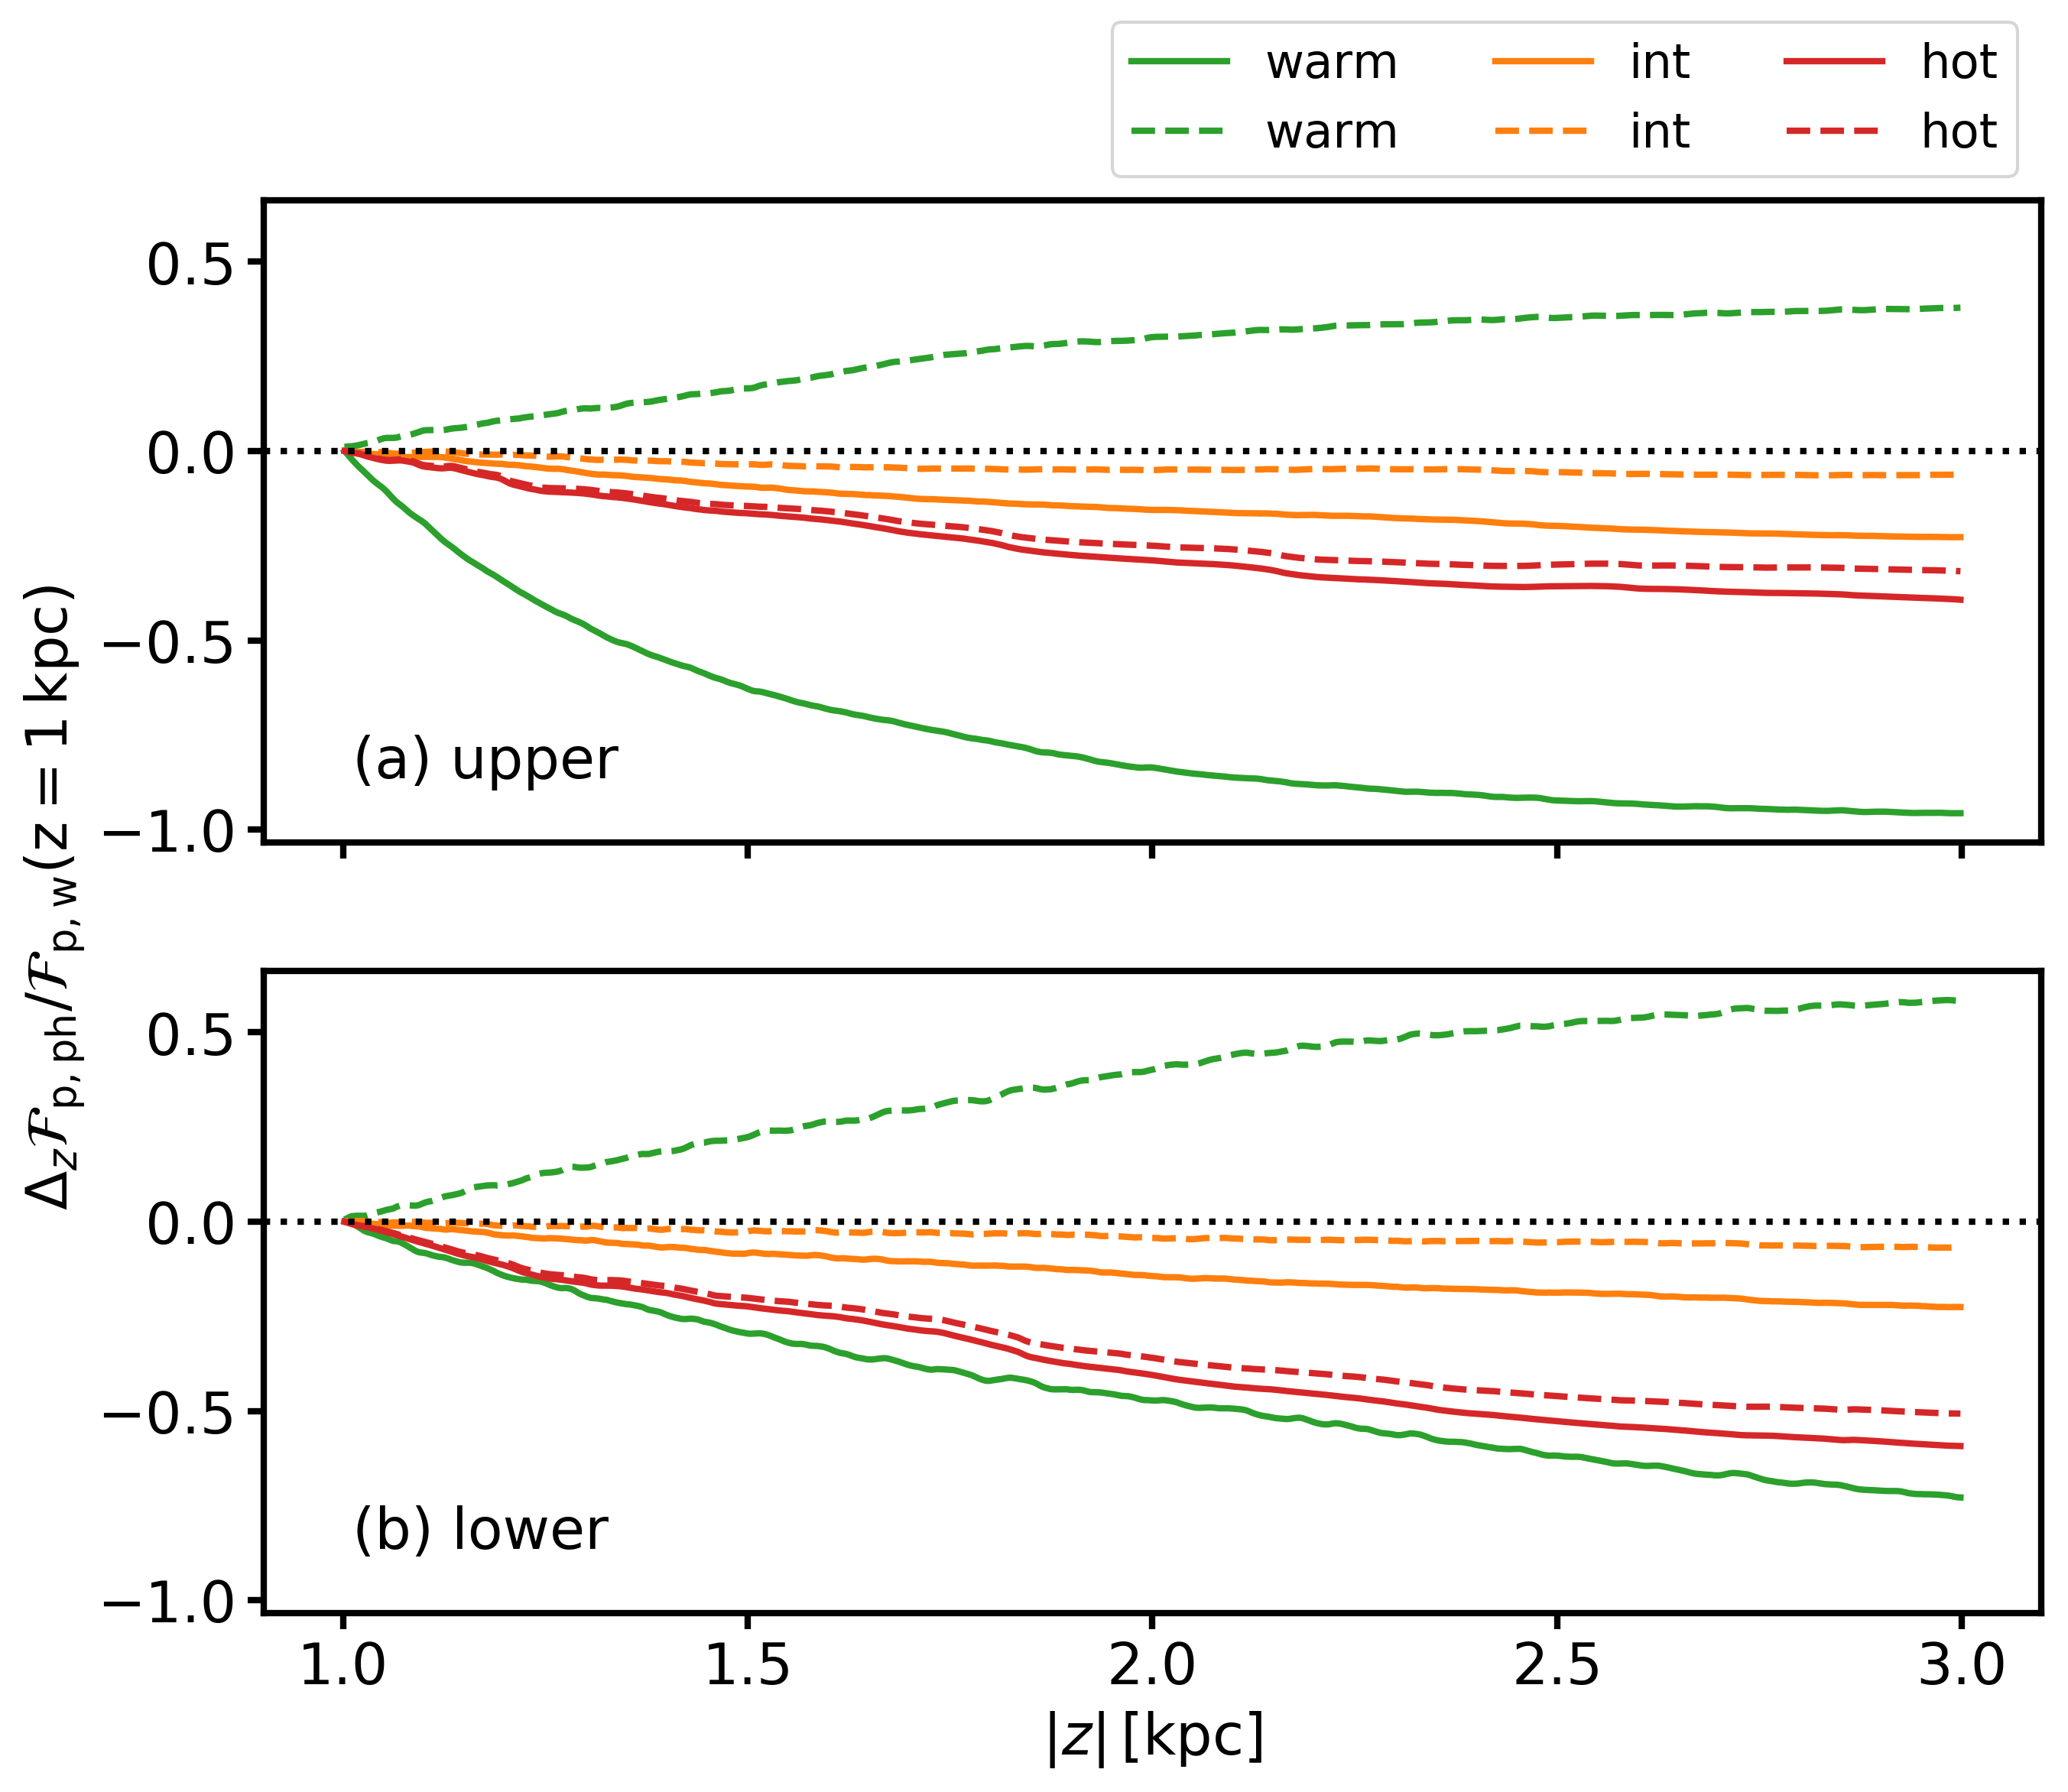

In [15]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],
                                  [dqdt_u['m_flux'],dqdt_l['m_flux']],
                                  axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['p_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in davg.coords['phase'].data[:-1]:
        ax.plot(davg.zaxis/1.e3,davg['p_flux'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=ph)
        ax.plot(davg.zaxis/1.e3,davg['p_balance'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=ph,ls='--')
#    ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,
#            ls='--',color='k',label=r'$-\langle\dot{p}\rangle/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.1,label,transform=ax.transAxes)
    #ax.set_ylim(-0.7,0.7)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.02, 0.5, r'$\Delta_z\mathcal{F}_{\rm p,ph}/\mathcal{F}_{\rm p,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=3,fontsize='small')
fig.savefig('../supplement/momentum_conservation_noW.pdf',bbox_inches='tight')
fig

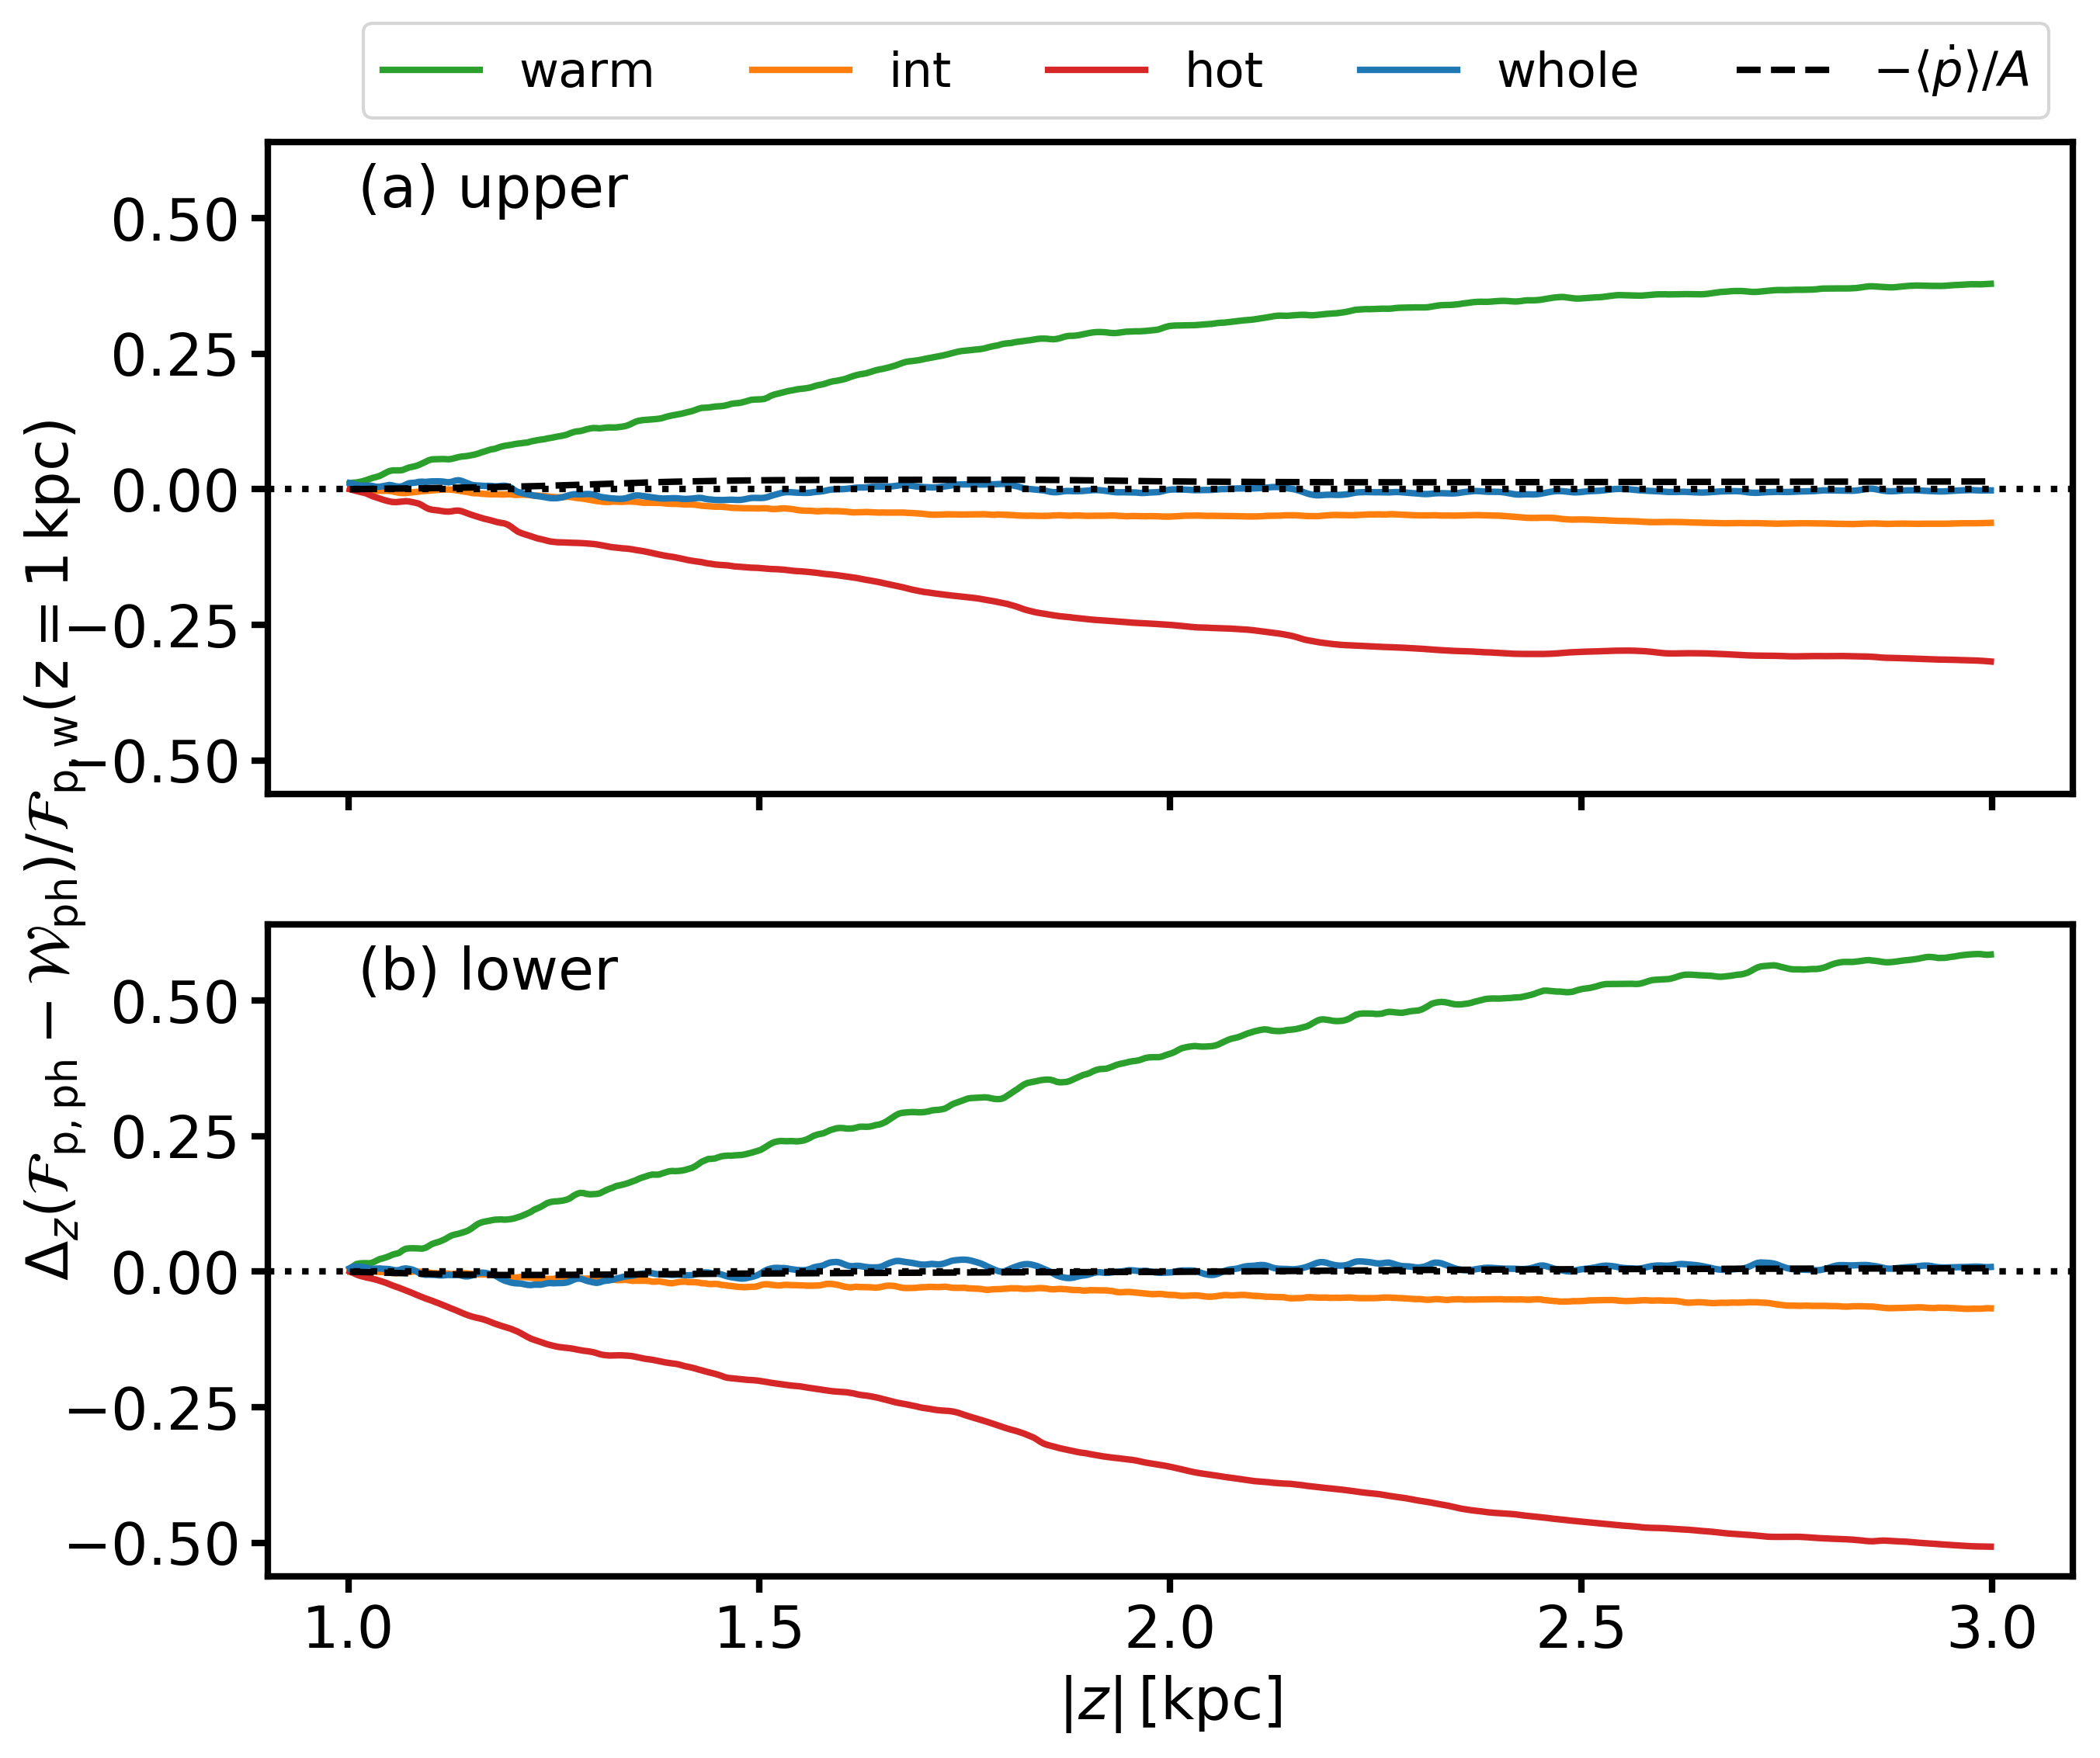

In [16]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],
                                  [dqdt_u['m_flux'],dqdt_l['m_flux']],
                                  axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['p_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,davg['p_balance'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=ph)
    ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,
            ls='--',color='k',label=r'$-\langle\dot{p}\rangle/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    #ax.set_ylim(-0.7,0.7)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.02, 0.5, r'$\Delta_z(\mathcal{F}_{\rm p,ph}-\mathcal{W}_{\rm ph})/\mathcal{F}_{\rm p,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../figures/momentum_conservation.pdf',bbox_inches='tight')
fig

# Figure: energy conservation

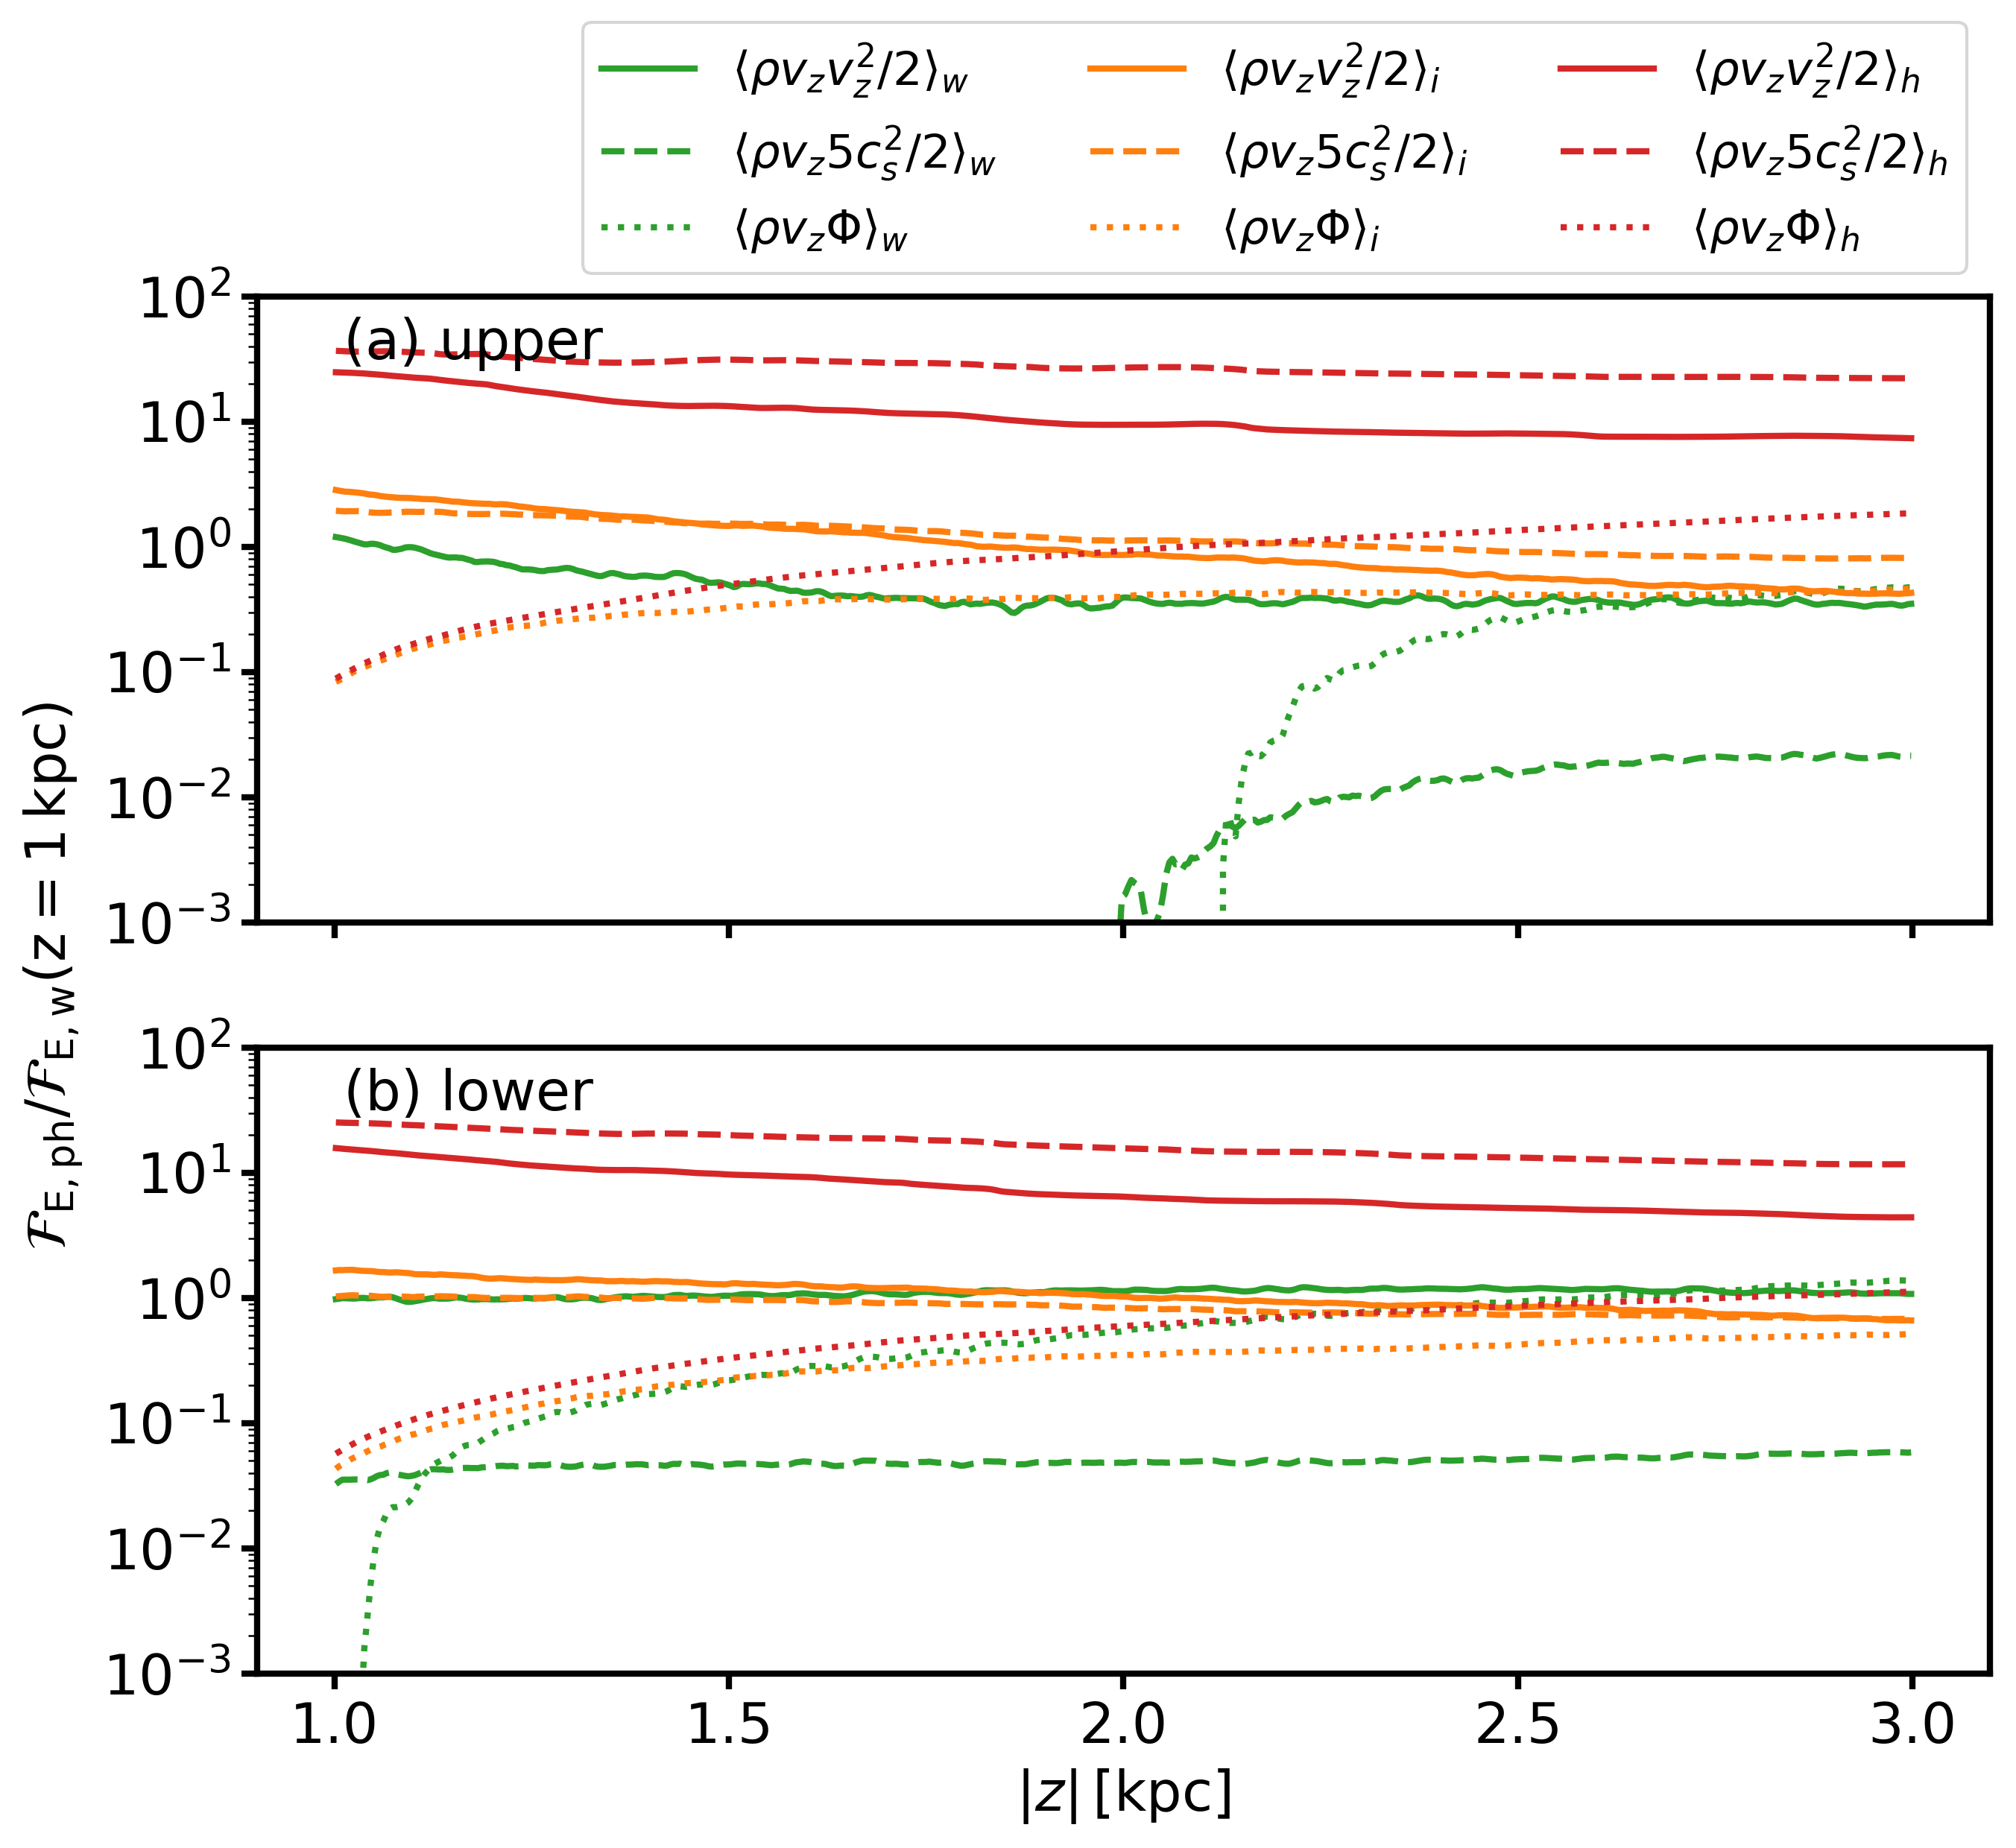

In [17]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,esn,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],
                                  [dc.esn_u,dc.esn_l],
                                  axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['e_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
#    ref=esn[-1]
    for ph in avg.coords['phase'].data[:-1]:
        #ref=(avg['e_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase=ph))
        ax.plot(avg.zaxis/1.e3,avg['ekin_flux'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=r'$\langle\rho v_z v_z^2/2\rangle_{}$'.format(ph[0]))
        ax.plot(avg.zaxis/1.e3,avg['eth_flux'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=r'$\langle\rho v_z 5c_s^2/2\rangle_{}$'.format(ph[0]),ls='--')
        ax.plot(avg.zaxis/1.e3,avg['eg_flux'].sel(phase=ph)/ref,
                color=dc.colors[ph],label=r'$\langle\rho v_z \Phi\rangle_{}$'.format(ph[0]),ls=':')
#    ax.plot(dqdt_u.zaxis/1.e3,esn/ref.data,ls='--',color='k',label=r'$(\dot{E}_{\rm SN}/A)$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    #ax.set_ylim(-1.5,1.5)
    #ax.axhline(1,ls=':')
    ax.set_xticks([1,1.5,2,2.5,3])
    ax.set_yscale('log')
    ax.set_ylim(1.e-3,100)
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.02, 0.5, r'$\mathcal{F}_{\rm E,ph}/\mathcal{F}_{\rm E,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
#axes[1].set_ylabel(r'$\Delta\mathcal{F}_{E,c}(z)/(\dot{E}_{\rm SN}/A)$')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=3,fontsize='small')
fig.savefig('../supplement/energy_flux_profile.pdf',bbox_inches='tight')
fig

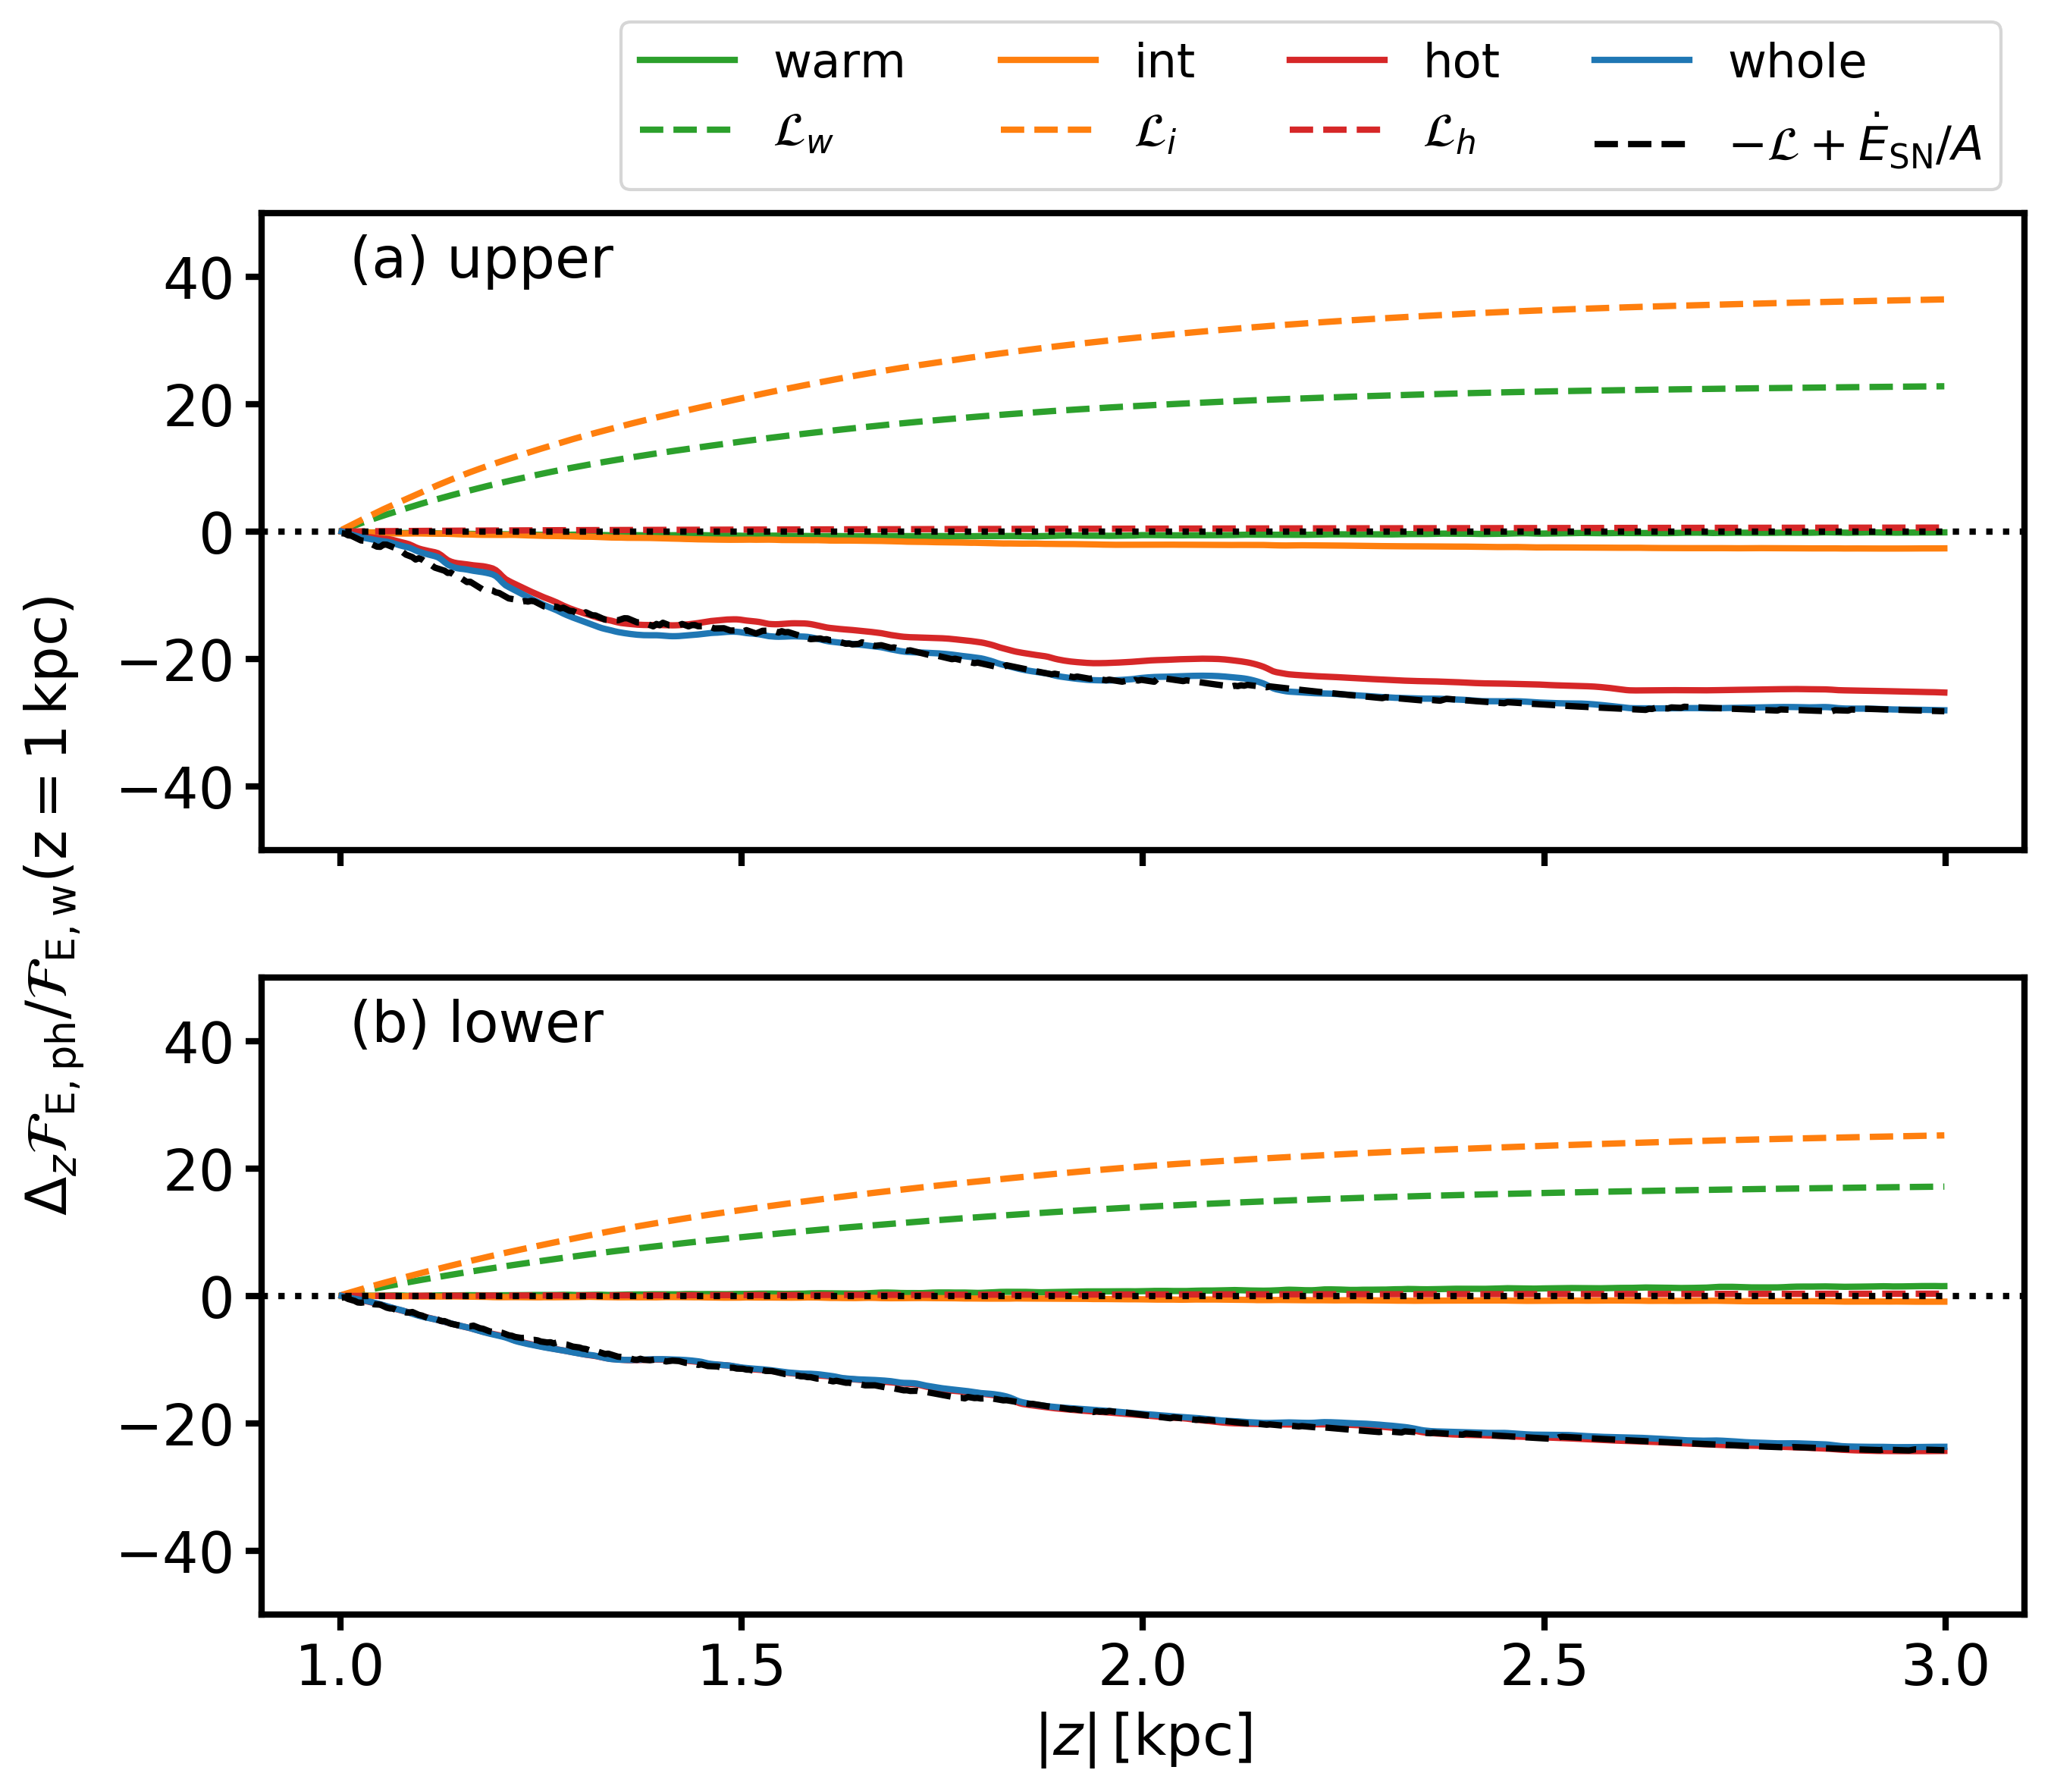

In [18]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,esn,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],
                                  [dc.esn_u,dc.esn_l],
                                  axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['ekin_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
#    ref=esn[-1]
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,davg['e_flux'].sel(phase=ph)/ref,color=dc.colors[ph],label=ph)
#    for ph in davg.coords['phase'].data:
        if ph != 'whole': 
            ax.plot(davg.zaxis/1.e3,avg['netcool'].sel(phase=ph)/ref,color=dc.colors[ph],
                label=r'$\mathcal{{L}}_{}$'.format(ph[0]),ls='--')
    ax.plot(dqdt_u.zaxis/1.e3,(+esn-avg['netcool'].sel(phase='whole'))/ref.data,ls='--',color='k',
            label=r'$-\mathcal{L}+\dot{E}_{\rm SN}/A$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    ax.set_ylim(-50,50)
    #ax.axhline(1,ls=':')
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
fig.text(0.02, 0.5, r'$\Delta_z\mathcal{F}_{\rm E,ph}/\mathcal{F}_{\rm E,w}({\rm z=1\,kpc})$',
         va='center', rotation='vertical')
#axes[1].set_ylabel(r'$\Delta\mathcal{F}_{E,c}(z)/(\dot{E}_{\rm SN}/A)$')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=4,fontsize='small')
fig.savefig('../figures/energy_conservation.pdf',bbox_inches='tight')
fig

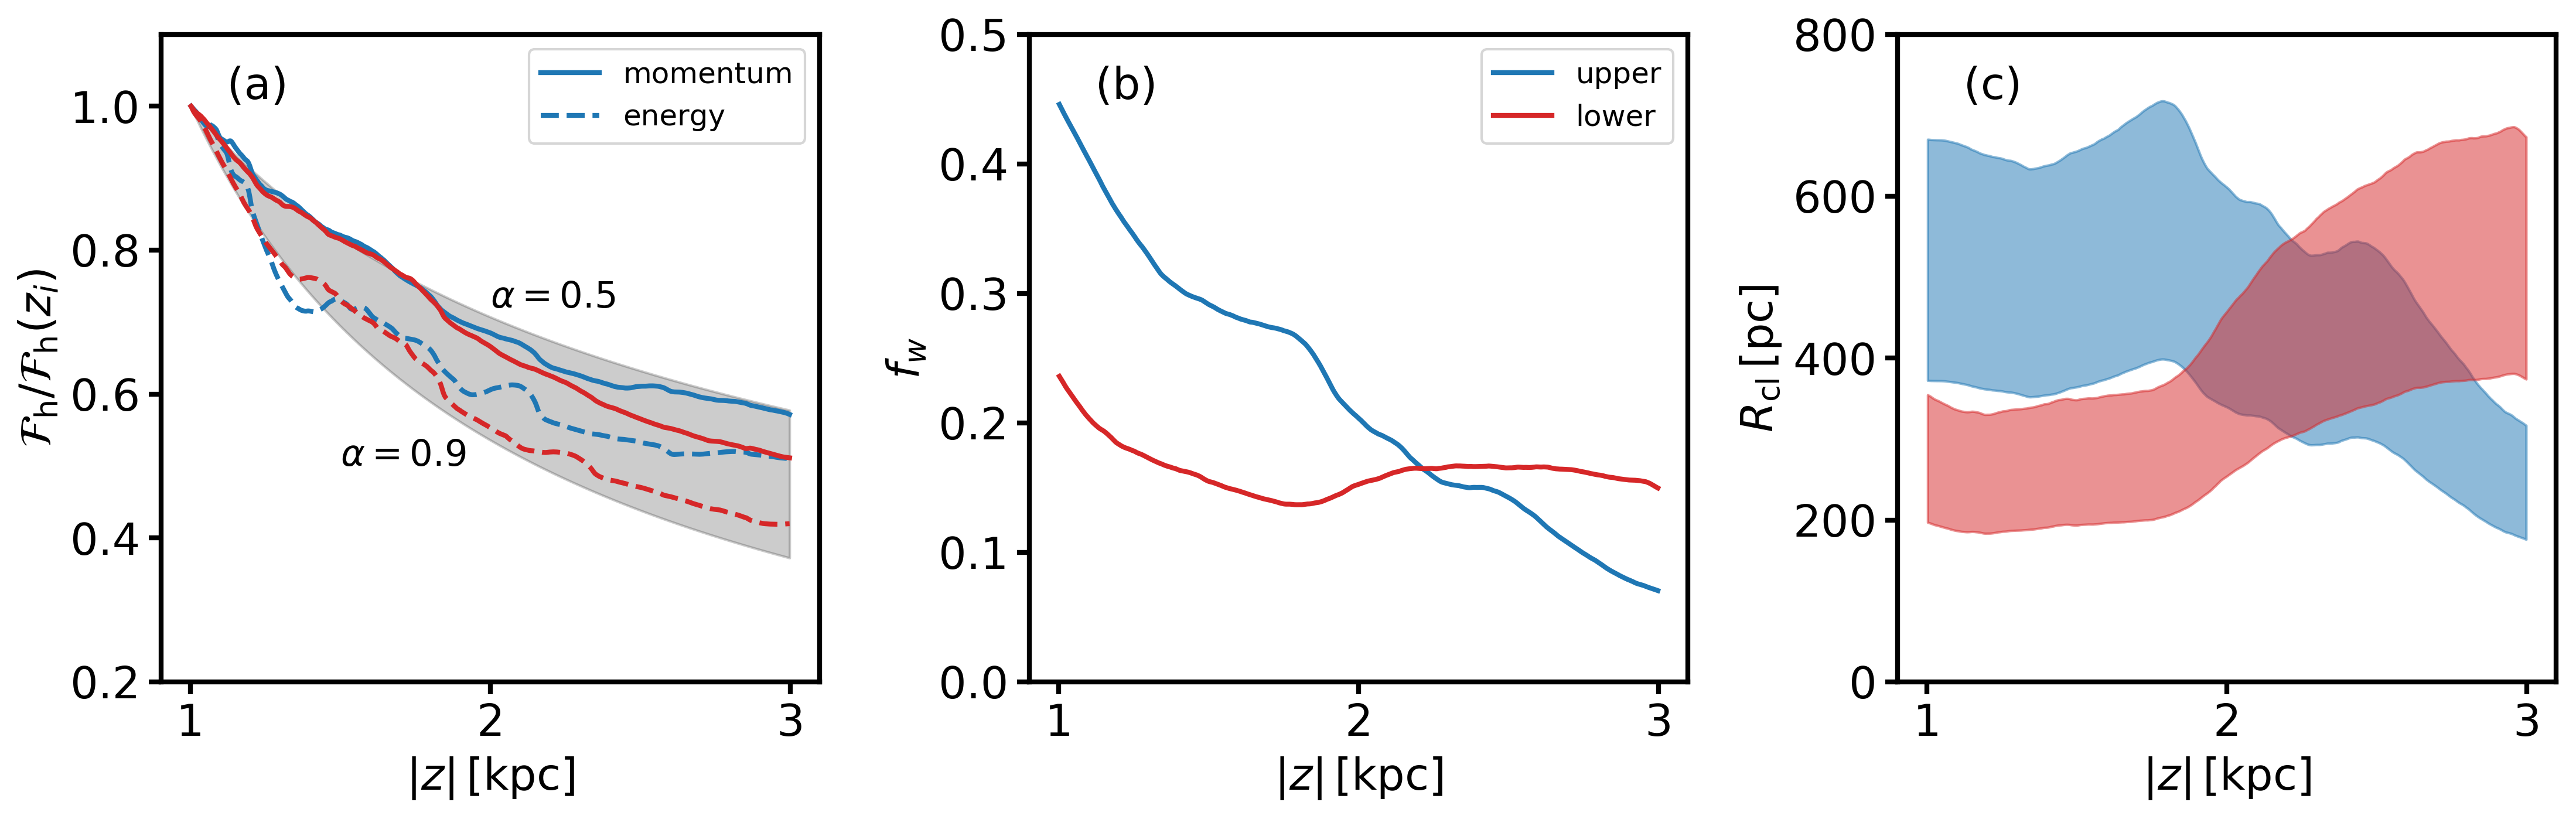

In [19]:
fig,axes = plt.subplots(1,3,figsize=(15,5))#,gridspec_kw={'wspace':0.4})

ax=axes[0]
alpha=[0.5,0.9]
for avg,color in zip([avg_u,avg_l],['C0','C3']):
    z0=1.e3
    z=avg.zaxis
    Fph=(avg['p_flux']).sel(phase='hot')
    Feh=(avg['e_flux']).sel(phase='hot')
    for Fh,ls in zip([Fph,Feh],['-','--']):
        ax.plot(z/1.e3,Fh/Fh[0],color=color,ls=ls)
lines=ax.lines
l1=ax.legend(lines[:2],['momentum','energy'],fontsize=12)
ax.fill_between(z/1.e3,(z0/z)**(alpha[0]),(z0/z)**(alpha[1]),alpha=0.2,color='k')
ax.text(2,0.72,r'$\alpha={}$'.format(alpha[0]),fontsize='small')
ax.text(1.5,0.5,r'$\alpha={}$'.format(alpha[1]),fontsize='small')
ax.set_ylabel(r'$\mathcal{F}_{\rm h}/\mathcal{F}_{\rm h}(z_i)$')
ax.set_ylim(0.2,1.1)
ax=axes[1]
for avg,color in zip([avg_u,avg_l],['C0','C3']):
    z0=1.e3
    z=avg.zaxis
    fw=avg['A'].sel(phase='warm')
    ax.plot(z/1.e3,fw,color=color)
# ax.fill_between(z,0.5*(z/z0)**(-1),0.5*(z/z0)**(-2),alpha=0.2,color='k')
ax.set_ylim(0,0.5)
lines=ax.lines
ax.legend(lines,['upper','lower'],fontsize=12)
ax.set_ylabel(r'$f_w$')

ax=axes[2]
for avg,color in zip([avg_u,avg_l],['C0','C3']):
    fw=avg['A'].sel(phase='warm')

    z=avg.zaxis
    Rcl1=0.75/alpha[0]*fw*z
    Rcl2=0.75/alpha[1]*fw*z
    ax.fill_between(z/1.e3,Rcl1,Rcl2,color=color,alpha=0.5)

ax.set_ylim(0,800)
ax.set_ylabel(r'$R_{\rm cl}\,[{\rm pc}]$')
for ax,let in zip(axes,'abc'):
    ax.text(0.1,0.9,'({})'.format(let),transform=ax.transAxes,**texteffect(18))
plt.setp(axes,'xlabel',r'$|z|\,[{\rm kpc}]$')
plt.tight_layout()
fig.savefig('../figures/Rcl.pdf',bbox_inches='tight')
fig

In [20]:
for avg in [avg_u,avg_l]:
    Fph=(avg['p_flux_kin']+avg['P']).sel(phase='hot')
    Feh=(avg['ekin_flux']+avg['eth_flux']).sel(phase='hot')   
    for Fh in [Fph,Feh]:
        dlnFdz=-np.log(Fh.rolling(zaxis=50,min_periods=1,center=True).mean()).differentiate('zaxis')
        (dlnFdz).plot()
z0=1.e3
z=avg.zaxis
plt.fill_between(z,0.5/z,1/z,alpha=0.5)

In [21]:
for avg in [avg_u,avg_l]:
    Vw=avg['A'].sel(phase='warm')*dc.totarea*dc.deltaz
    V=avg['A'].sel(phase='whole')*dc.totarea*dc.deltaz
    fw=Vw.groupby_bins('zaxis',np.arange(1000,3500,500)).sum()/V.groupby_bins('zaxis',np.arange(1000,3500,500)).sum()
#    fw=(Vw.cumsum()/V.cumsum())
    fw.plot(marker='o',ls='-')
    avg['A'].sel(phase='warm').plot()
#     z=avg.zaxis
#     Rcl1=0.75/alpha[0]*fw*z
#     Rcl2=0.75/alpha[1]*fw*z
#     plt.fill_between(z/1.e3,Rcl1,Rcl2,alpha=0.5)
